# Антифрод в DeFi

In [2]:
import pandas as pd
import numpy as np
from imblearn.under_sampling  import RandomUnderSampler
from collections import Counter

## Имя выполняющего: 

Привет!

В данном проекте мы попытаемся классифицировать вредоносные смарт-контракты используя его байткод.
Стоить заметить, что задача будет предсказать именно метки 1 и 0, а не просто получить скоры :)

Проект будет состоять из двух частей:

1) ML часть 
2) Инфраструктурная часть

Давайте начнем с ML части и разберемся с моделью.

Загрузим датасет используя файл с расширением parquet.

In [3]:
data = pd.read_parquet('../Data/malicious_contract_training_dataset_final.parquet', engine='fastparquet')


Посмотрим что у нас вообще есть в данных?

In [4]:
data.head()

,contract_address,contract_name,contract_etherscan_label,contract_tag,contract_creator,contract_creation_tx,creation_bytecode,decompiled_opcodes,malicious,contract_creator_tag,source,notes,contract_creator_etherscan_label,block
82965,0x04ae3226c80e8c04d35e6e56089345bdd06da6de,,,Multichain Exploiter 10,0x98f5b0a99f258a09403d965647ee9d53677914af,0xe962b06db95db1dedb8b1664bf93bb8816c0cfbd1876...,0x6080604052600180546001600160a01b03191673c02a...,PUSH1 0x80 PUSH1 0x40 MSTORE PUSH1 0x01 DUP1 S...,True,,Luabase ethereum.tags table,,exploit,14041572
82966,0xc5ac25cfc2b8284e84ca47dad21cf1319f732c11,,,,0x07e02088d68229300ae503395c6536f09179dc3e,0xae03b08f220e5d7750e97e67ea85ac6e69649f6fd6d8...,0x60a0604052600180553373ffffffffffffffffffffff...,PUSH1 0xa0 PUSH1 0x40 MSTORE PUSH1 0x01 DUP1 S...,True,xToken Exploiter,Luabase ethereum.tags table,,heist,12419856
82967,0x79dbe9bbde91a35fa8148a14084979a531fe57ea,,,,0x11112f684cb88d43ca0e132e585e882606063fbe,0x07766fa0cb09dc5221763049c4a2fbbf3556c8660490...,0x6080604052600080546001600160a01b031990811673...,PUSH1 0x80 PUSH1 0x40 MSTORE PUSH1 0x00 DUP1 S...,True,Malicious Actor (Exploit Abuser),Luabase ethereum.tags table,,heist,13693565
82968,0x3b1ea5b11d12452693f9bd290ac2100394e6850f,,,,0x11112f684cb88d43ca0e132e585e882606063fbe,0x10c93b07d287419254869c45c2323df43110cfd29443...,0x6080604052600080546001600160a01b031990811673...,PUSH1 0x80 PUSH1 0x40 MSTORE PUSH1 0x00 DUP1 S...,True,Malicious Actor (Exploit Abuser),Luabase ethereum.tags table,,heist,13701626
82969,0x682dcf2f4a6e46c222927a54529b4965fb313bf2,,,,0x11112f684cb88d43ca0e132e585e882606063fbe,0x961f42e3a9986fb1ab15f2bc36434cb9e0d6739bf331...,0x6080604052600080546001600160a01b031990811673...,PUSH1 0x80 PUSH1 0x40 MSTORE PUSH1 0x00 DUP1 S...,True,Malicious Actor (Exploit Abuser),Luabase ethereum.tags table,,heist,13787473


Ага, что мы имеем? 

Есть колонка 'decompiled_opcodes' - это и будет нашими фичами

Malicious - наш таргет

In [5]:
print('Class balance',Counter(data.malicious))

Class balance Counter({False: 50800, True: 127})


Как видно, у нас имеется значительный дисбаланс классов, что на самом деле и соответствует реальности. 

Как ни крути, не все юзеры блокчейна занимаются непотребствами.

## Предобработка данных (1 балл)

Давайте предобработаем данные, важно понимать что в байткоде будут иметься сигнатуры и адреса других контрактов

Может ли это быть полезно?

Это будет зависеть от вас

В данной секции от вас ожидается предобработка данных

Визуализация и анализ природы данных - необязательны, но желательны, если найдете что-то интересное - мы это вам зачтем в виде бонуса +1 балл :) 

In [6]:
from sklearn.model_selection import train_test_split

In [8]:
## Вжух - ваш код тут
opcodes = np.array(['STOP', 'ADD', 'MUL', 'SUB','DIV','SDIV', 'MOD', 'SMOD',
    'ADDMOD', 'MULMOD', 'EXP', 'SIGNEXTEND', 'LT', 'GT', 'SLT', 'SGT',
    'EQ', 'ISZERO', 'AND', 'OR', # 'EVMOR'
    'XOR', 'NOT', 'BYTE', 'SHL', 'SHR', 'SAR', 'SHA3', 'ADDRESS', 'BALANCE', 'ORIGIN', 'CALLER', 'CALLVALUE',
    'CALLDATALOAD', 'CALLDATASIZE', 'CALLDATACOPY', 'CODESIZE', 'CODECOPY', 'GASPRICE', 'EXTCODESIZE', 'EXTCODECOPY',
    'RETURNDATASIZE', 'RETURNDATACOPY', 'EXTCODEHASH', 'BLOCKHASH', 'COINBASE', 'TIMESTAMP', 'NUMBER', 'DIFFICULTY',
    'GASLIMIT', 'POP', 'MLOAD', 'MSTORE', 'MSTORE8', 'SLOAD', 'SSTORE', 'JUMP', 'JUMPI', 'PC', 'MSIZE', 'GAS', 'JUMPDEST', 
    'PUSH1', 'PUSH2', 'PUSH3', 'PUSH4', 'PUSH5', 'PUSH6', 'PUSH7', 'PUSH8', 'PUSH9', 'PUSH10', 'PUSH11', 'PUSH12', 'PUSH13', 'PUSH14', 'PUSH15',
    'PUSH16', 'PUSH17', 'PUSH18', 'PUSH19', 'PUSH20', 'PUSH21', 'PUSH22', 'PUSH23', 'PUSH24', 'PUSH25', 'PUSH26', 'PUSH27', 'PUSH28', 'PUSH29', 'PUSH30', 
    'PUSH31', 'PUSH32', 'DUP1', 'DUP2', 'DUP3', 'DUP4', 'DUP5', 'DUP6', 'DUP7', 'DUP8', 'DUP9', 'DUP10', 'DUP11', 'DUP12', 'DUP13', 'DUP14', 'DUP15',
    'DUP16', 'SWAP1', 'SWAP2', 'SWAP3', 'SWAP4', 'SWAP5', 'SWAP6', 'SWAP7', 'SWAP8', 'SWAP9', 'SWAP10', 'SWAP11', 'SWAP12', 'SWAP13', 'SWAP14', 'SWAP15',
    'SWAP16', 'LOG0', 'LOG1', 'LOG2', 'LOG3', 'LOG4', 'CREATE', 'CALL', 'CALLCODE', 'RETURN', 'DELEGATECALL', 'CREATE2', 'STATICCALL', 'REVERT', 'INVALID', 'SELFDESTRUCT',
    #   'ff' : 'SUICIDE',
    ])
def count_opcodes(decoded_opcodes: str):
    count = lambda opcode: decoded_opcodes.count(opcode)
    return np.fromiter(map(count, opcodes), int, len(opcodes))
X = pd.DataFrame(columns=opcodes, data = np.stack(np.fromiter(map(count_opcodes, data['decompiled_opcodes']), np.ndarray, len(data))), index = np.arange(len(data)))

X


,STOP,ADD,MUL,SUB,DIV,SDIV,MOD,SMOD,ADDMOD,MULMOD,...,CREATE,CALL,CALLCODE,RETURN,DELEGATECALL,CREATE2,STATICCALL,REVERT,INVALID,SELFDESTRUCT
0,4,37,1,23,1,0,1,0,1,0,...,1,36,0,8,0,1,0,25,0,0
1,6,559,32,102,2,0,0,0,0,0,...,0,92,0,238,0,0,25,196,0,0
2,2,241,5,104,0,0,0,0,0,0,...,1,50,0,101,0,0,8,81,1,0
3,3,39,0,8,0,0,2,1,1,0,...,0,11,0,10,0,0,1,11,0,0
4,3,82,4,26,0,0,2,1,1,0,...,0,22,0,10,0,0,2,19,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50922,3,174,21,57,24,0,0,0,0,0,...,0,58,0,18,0,0,0,18,1,0
50923,118,578,38,300,25,1,1,0,0,0,...,3,211,0,46,0,3,3,187,0,124
50924,4,181,6,87,6,0,3,0,1,0,...,1,78,1,32,0,1,3,60,0,0
50925,214,521,46,167,34,0,5,1,3,0,...,0,90,1,28,0,0,0,103,0,0


In [9]:
y = data.malicious.astype(int)

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.40, random_state=42, stratify= y )
# X_test, X_val, y_test, y_val = train_test_split( X_test, y_test, test_size=0.30, random_state=42, stratify= y_test )

## Модель (5 баллов)

Итак перед вами стоит задача классифицировать смарт-контракты.

Представьте что вы глава проекта из https://cyvers.ai/ 

Вы разрабатываете софт для фондов, которые вкладывает деньги в различные DeFi протоколы и им важно своевременно выводить деньги.

Перед вами стоит задача разработать предиктивный софт по DeFi безопасности, возникает несколько вопросов:

1) Выбор модели на ваше усмотрение, помните что потом эту модель вам нужно будет использовать в инфраструктурном коде
2) Помните, что модель нужна для своевременного реагирования на угрозу, важна ли здесь скорость инференса?
3) Является ли более предпочтительной интепретируемость, либо более эффективная модель, но блек бокс?
4) Как вы думаете, что важнее в нашей задаче precision или recall?
5) Как именно вы будете работать с дисбалансом классом, а именно какую метрику выберете?

Все это решать вам)

Ваши рассуждения и комментарии в ноутбуке - также влияют на оценку, поэтому не стесняйтесь рассуждать, важна ваши мысльё

In [11]:

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt 

In [ ]:
# ## Вжух ваш код тут

# clf = GradientBoostingClassifier(learning_rate=1, max_depth=8, random_state=0).fit(X_train, y_train)

# print(f1_score(y_test, clf.predict(X_test)))


In [ ]:
# RF = RandomForestClassifier(max_depth=100, random_state=0, n_estimators=1000).fit(X_train, y_train)

# print(f1_score(y_test, clf.predict(X_test)))

In [12]:
logreg = LogisticRegression(C=.25, penalty='l2', random_state=0, max_iter=800).fit(X_train, y_train)

print(f1_score(y_test, logreg.predict(X_test)))

0.6382978723404256


/home/owner/Documents/DEV/FINTECH/Проект ФКН Финтех 2023/ProjectFCS/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# SVM = SGDClassifier(penalty='elasticnet', random_state=0).fit(X_train, y_train)

# print(f1_score(y_test, SVM.predict(X_test)))

In [15]:
import pickle
filename = '../Model/finalized_model.sav'
pickle.dump(logreg, open(filename, 'wb'))

## Анализ результатов и ваши метрики (1 балл)

### Посмотрим на метрики

------------------------------------TESTING INFO-------------------------------------------------
F1 on test - 0.6451612903225806
precision on test - 0.7692307692307693
recall on test - 0.5555555555555556


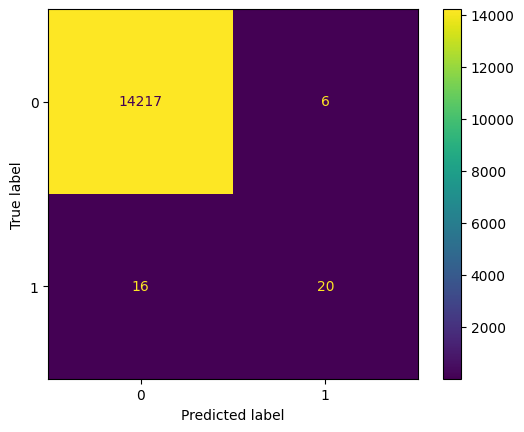

In [ ]:
y_pred = logreg.predict(X_test)# ваши скоры на тесте
y_pred_c = logreg.predict(X_test)# метки класса на тесте
# y_test = # метки на тесте

print('------------------------------------TESTING INFO-------------------------------------------------')
# Метрики которые вы считаете важными
print(f'F1 on test - {f1_score(y_test, y_pred_c)}')
print(f'precision on test - {precision_score(y_test, y_pred_c)}')
print(f'recall on test - {recall_score(y_test, y_pred_c)}')

cm = confusion_matrix(y_test, y_pred_c, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])
disp.plot()
plt.show()

### Посмотрим на распределение скоров модели на тесте

In [ ]:
plt.hist(y_pred[y_test==0])
plt.show()
plt.hist(y_pred[y_test==1])
plt.show()

### Интерпретируемость модели

In [ ]:
# Вжух ваша интерпретация если она есть

### Тесты на реальных данных

Testing for https://etherscan.io/address/0xcff07c4e6aa9e2fec04daaf5f41d1b10f3adadf4

This is a https://rekt.news/teamfinance-rekt/ malicious contract

In [ ]:
team_finance_exploit = 
"""
PUSH1 0x80
PUSH1 0x40
MSTORE
PUSH1 0x04
CALLDATASIZE
LT
PUSH2 0x012a
JUMPI
PUSH1 0x00
CALLDATALOAD
PUSH1 0xe0
SHR
DUP1
PUSH4 0x90f84d44
GT
PUSH2 0x00ab
JUMPI
DUP1
PUSH4 0xd8cd4768
GT
PUSH2 0x006f
JUMPI
DUP1
PUSH4 0xd8cd4768
EQ
PUSH2 0x02cf
JUMPI
DUP1
PUSH4 0xe0cec5b0
EQ
PUSH2 0x02d7
JUMPI
DUP1
PUSH4 0xef14df91
EQ
PUSH2 0x02df
JUMPI
DUP1
PUSH4 0xf9b65204
EQ
PUSH2 0x02ff
JUMPI
DUP1
PUSH4 0xf9e1033d
EQ
PUSH2 0x031f
JUMPI
DUP1
PUSH4 0xfcc14a4a
EQ
PUSH2 0x0334
JUMPI
PUSH2 0x012a
JUMP
JUMPDEST
DUP1
PUSH4 0x90f84d44
EQ
PUSH2 0x022f
JUMPI
DUP1
PUSH4 0x92bb2fe1
EQ
PUSH2 0x024f
JUMPI
DUP1
PUSH4 0x968d0f67
EQ
PUSH2 0x026f
JUMPI
DUP1
PUSH4 0xaf615575
EQ
PUSH2 0x0277
JUMPI
DUP1
PUSH4 0xd3a9ef39
EQ
PUSH2 0x0297
JUMPI
PUSH2 0x012a
JUMP
JUMPDEST
DUP1
PUSH4 0x3bc4a8f9
GT
PUSH2 0x00f2
JUMPI
DUP1
PUSH4 0x3bc4a8f9
EQ
PUSH2 0x01b2
JUMPI
DUP1
PUSH4 0x3cee1b99
EQ
PUSH2 0x01d2
JUMPI
DUP1
PUSH4 0x5d5c17a3
EQ
PUSH2 0x01e5
JUMPI
DUP1
PUSH4 0x607a686e
EQ
PUSH2 0x01fa
JUMPI
DUP1
PUSH4 0x866a09d9
EQ
PUSH2 0x021a
JUMPI
PUSH2 0x012a
JUMP
JUMPDEST
DUP1
PUSH4 0x0e9fedde
EQ
PUSH2 0x012c
JUMPI
DUP1
PUSH4 0x1cdc2299
EQ
PUSH2 0x013f
JUMPI
DUP1
PUSH4 0x1f75249b
EQ
PUSH2 0x0154
JUMPI
DUP1
PUSH4 0x23365d22
EQ
PUSH2 0x017e
JUMPI
DUP1
PUSH4 0x35b5f7ab
EQ
PUSH2 0x0191
JUMPI
JUMPDEST
STOP
JUMPDEST
PUSH2 0x012a
PUSH2 0x013a
CALLDATASIZE
PUSH1 0x04
PUSH2 0x2416
JUMP
JUMPDEST
PUSH2 0x0354
JUMP
JUMPDEST
CALLVALUE
DUP1
ISZERO
PUSH2 0x014b
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
POP
PUSH2 0x012a
PUSH2 0x047a
JUMP
JUMPDEST
PUSH2 0x0167
PUSH2 0x0162
CALLDATASIZE
PUSH1 0x04
PUSH2 0x2587
JUMP
JUMPDEST
PUSH2 0x04a5
JUMP
JUMPDEST
PUSH1 0x40
MLOAD
PUSH2 0x0175
SWAP3
SWAP2
SWAP1
PUSH2 0x273b
JUMP
JUMPDEST
PUSH1 0x40
MLOAD
DUP1
SWAP2
SUB
SWAP1
RETURN
JUMPDEST
PUSH2 0x012a
PUSH2 0x018c
CALLDATASIZE
PUSH1 0x04
PUSH2 0x24be
JUMP
JUMPDEST
PUSH2 0x0533
JUMP
JUMPDEST
PUSH2 0x01a4
PUSH2 0x019f
CALLDATASIZE
PUSH1 0x04
PUSH2 0x23d7
JUMP
JUMPDEST
PUSH2 0x077d
JUMP
JUMPDEST
PUSH1 0x40
MLOAD
SWAP1
DUP2
MSTORE
PUSH1 0x20
ADD
PUSH2 0x0175
JUMP
JUMPDEST
CALLVALUE
DUP1
ISZERO
PUSH2 0x01be
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
POP
PUSH2 0x012a
PUSH2 0x01cd
CALLDATASIZE
PUSH1 0x04
PUSH2 0x26c3
JUMP
JUMPDEST
PUSH2 0x08f5
JUMP
JUMPDEST
PUSH2 0x0167
PUSH2 0x01e0
CALLDATASIZE
PUSH1 0x04
PUSH2 0x25d5
JUMP
JUMPDEST
PUSH2 0x0950
JUMP
JUMPDEST
CALLVALUE
DUP1
ISZERO
PUSH2 0x01f1
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
POP
PUSH2 0x012a
PUSH2 0x09df
JUMP
JUMPDEST
CALLVALUE
DUP1
ISZERO
PUSH2 0x0206
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
POP
PUSH2 0x012a
PUSH2 0x0215
CALLDATASIZE
PUSH1 0x04
PUSH2 0x26c3
JUMP
JUMPDEST
PUSH2 0x0ade
JUMP
JUMPDEST
CALLVALUE
DUP1
ISZERO
PUSH2 0x0226
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
POP
PUSH2 0x012a
PUSH2 0x0b36
JUMP
JUMPDEST
CALLVALUE
DUP1
ISZERO
PUSH2 0x023b
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
POP
PUSH2 0x012a
PUSH2 0x024a
CALLDATASIZE
PUSH1 0x04
PUSH2 0x244e
JUMP
JUMPDEST
PUSH2 0x0c2c
JUMP
JUMPDEST
CALLVALUE
DUP1
ISZERO
PUSH2 0x025b
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
POP
PUSH2 0x012a
PUSH2 0x026a
CALLDATASIZE
PUSH1 0x04
PUSH2 0x2664
JUMP
JUMPDEST
PUSH2 0x0e55
JUMP
JUMPDEST
PUSH2 0x012a
PUSH2 0x11e3
JUMP
JUMPDEST
CALLVALUE
DUP1
ISZERO
PUSH2 0x0283
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
POP
PUSH2 0x012a
PUSH2 0x0292
CALLDATASIZE
PUSH1 0x04
PUSH2 0x26c3
JUMP
JUMPDEST
PUSH2 0x1214
JUMP
JUMPDEST
CALLVALUE
DUP1
ISZERO
PUSH2 0x02a3
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
POP
PUSH2 0x02b7
PUSH2 0x02b2
CALLDATASIZE
PUSH1 0x04
PUSH2 0x255c
JUMP
JUMPDEST
PUSH2 0x128d
JUMP
JUMPDEST
PUSH1 0x40
MLOAD
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
SWAP1
SWAP2
AND
DUP2
MSTORE
PUSH1 0x20
ADD
PUSH2 0x0175
JUMP
JUMPDEST
PUSH2 0x012a
PUSH2 0x1358
JUMP
JUMPDEST
PUSH2 0x012a
PUSH2 0x13ec
JUMP
JUMPDEST
CALLVALUE
DUP1
ISZERO
PUSH2 0x02eb
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
POP
PUSH2 0x012a
PUSH2 0x02fa
CALLDATASIZE
PUSH1 0x04
PUSH2 0x26c3
JUMP
JUMPDEST
PUSH2 0x141d
JUMP
JUMPDEST
CALLVALUE
DUP1
ISZERO
PUSH2 0x030b
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
POP
PUSH2 0x012a
PUSH2 0x031a
CALLDATASIZE
PUSH1 0x04
PUSH2 0x2664
JUMP
JUMPDEST
PUSH2 0x1447
JUMP
JUMPDEST
CALLVALUE
DUP1
ISZERO
PUSH2 0x032b
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
POP
PUSH2 0x012a
PUSH2 0x1a65
JUMP
JUMPDEST
CALLVALUE
DUP1
ISZERO
PUSH2 0x0340
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
POP
PUSH2 0x012a
PUSH2 0x034f
CALLDATASIZE
PUSH1 0x04
PUSH2 0x262c
JUMP
JUMPDEST
PUSH2 0x1b4c
JUMP
JUMPDEST
PUSH1 0x07
SLOAD
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
AND
CALLER
EQ
DUP1
PUSH2 0x036c
JUMPI
POP
CALLER
ADDRESS
EQ
JUMPDEST
PUSH2 0x0375
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
PUSH1 0x40
MLOAD
PUSH4 0x70a08231
PUSH1 0xe0
SHL
DUP2
MSTORE
ADDRESS
PUSH1 0x04
DUP3
ADD
MSTORE
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
DUP4
AND
SWAP1
PUSH4 0xa9059cbb
SWAP1
DUP4
SWAP1
DUP4
SWAP1
PUSH4 0x70a08231
SWAP1
PUSH1 0x24
ADD
JUMPDEST
PUSH1 0x20
PUSH1 0x40
MLOAD
DUP1
DUP4
SUB
DUP2
DUP7
DUP1
EXTCODESIZE
ISZERO
DUP1
ISZERO
PUSH2 0x03bf
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
POP
GAS
STATICCALL
ISZERO
DUP1
ISZERO
PUSH2 0x03d3
JUMPI
RETURNDATASIZE
PUSH1 0x00
DUP1
RETURNDATACOPY
RETURNDATASIZE
PUSH1 0x00
REVERT
JUMPDEST
POP
POP
POP
POP
PUSH1 0x40
MLOAD
RETURNDATASIZE
PUSH1 0x1f
NOT
PUSH1 0x1f
DUP3
ADD
AND
DUP3
ADD
DUP1
PUSH1 0x40
MSTORE
POP
DUP2
ADD
SWAP1
PUSH2 0x03f7
SWAP2
SWAP1
PUSH2 0x26db
JUMP
JUMPDEST
PUSH1 0x40
MLOAD
PUSH1 0x01
PUSH1 0x01
PUSH1 0xe0
SHL
SUB
NOT
PUSH1 0xe0
DUP6
SWAP1
SHL
AND
DUP2
MSTORE
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
SWAP1
SWAP3
AND
PUSH1 0x04
DUP4
ADD
MSTORE
PUSH1 0x24
DUP3
ADD
MSTORE
PUSH1 0x44
ADD
PUSH1 0x20
PUSH1 0x40
MLOAD
DUP1
DUP4
SUB
DUP2
PUSH1 0x00
DUP8
DUP1
EXTCODESIZE
ISZERO
DUP1
ISZERO
PUSH2 0x043d
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
POP
GAS
CALL
ISZERO
DUP1
ISZERO
PUSH2 0x0451
JUMPI
RETURNDATASIZE
PUSH1 0x00
DUP1
RETURNDATACOPY
RETURNDATASIZE
PUSH1 0x00
REVERT
JUMPDEST
POP
POP
POP
POP
PUSH1 0x40
MLOAD
RETURNDATASIZE
PUSH1 0x1f
NOT
PUSH1 0x1f
DUP3
ADD
AND
DUP3
ADD
DUP1
PUSH1 0x40
MSTORE
POP
DUP2
ADD
SWAP1
PUSH2 0x0475
SWAP2
SWAP1
PUSH2 0x2648
JUMP
JUMPDEST
POP
POP
POP
JUMP
JUMPDEST
PUSH1 0x07
SLOAD
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
AND
CALLER
EQ
DUP1
PUSH2 0x0492
JUMPI
POP
CALLER
ADDRESS
EQ
JUMPDEST
PUSH2 0x049b
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
PUSH2 0x04a3
PUSH2 0x0b36
JUMP
JUMPDEST
JUMP
JUMPDEST
PUSH1 0x07
SLOAD
PUSH1 0x00
SWAP1
PUSH1 0x60
SWAP1
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
AND
CALLER
EQ
DUP1
PUSH2 0x04c3
JUMPI
POP
CALLER
ADDRESS
EQ
JUMPDEST
PUSH2 0x04cc
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
DUP4
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
AND
CALLVALUE
DUP5
PUSH1 0x40
MLOAD
PUSH2 0x04e5
SWAP2
SWAP1
PUSH2 0x271f
JUMP
JUMPDEST
PUSH1 0x00
PUSH1 0x40
MLOAD
DUP1
DUP4
SUB
DUP2
DUP6
DUP8
GAS
CALL
SWAP3
POP
POP
POP
RETURNDATASIZE
DUP1
PUSH1 0x00
DUP2
EQ
PUSH2 0x0522
JUMPI
PUSH1 0x40
MLOAD
SWAP2
POP
PUSH1 0x1f
NOT
PUSH1 0x3f
RETURNDATASIZE
ADD
AND
DUP3
ADD
PUSH1 0x40
MSTORE
RETURNDATASIZE
DUP3
MSTORE
RETURNDATASIZE
PUSH1 0x00
PUSH1 0x20
DUP5
ADD
RETURNDATACOPY
PUSH2 0x0527
JUMP
JUMPDEST
PUSH1 0x60
SWAP2
POP
JUMPDEST
POP
SWAP2
POP
SWAP2
POP
SWAP3
POP
SWAP3
SWAP1
POP
JUMP
JUMPDEST
PUSH1 0x07
SLOAD
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
AND
CALLER
EQ
DUP1
PUSH2 0x054b
JUMPI
POP
CALLER
ADDRESS
EQ
JUMPDEST
PUSH2 0x0554
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
PUSH1 0x40
MLOAD
PUSH4 0xfeeb733d
PUSH1 0xe0
SHL
DUP2
MSTORE
ADDRESS
PUSH1 0x04
DUP3
ADD
MSTORE
PUSH1 0x00
SWAP1
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
DUP8
AND
SWAP1
PUSH4 0xfeeb733d
SWAP1
PUSH1 0x24
ADD
PUSH1 0x20
PUSH1 0x40
MLOAD
DUP1
DUP4
SUB
DUP2
PUSH1 0x00
DUP8
DUP1
EXTCODESIZE
ISZERO
DUP1
ISZERO
PUSH2 0x0598
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
POP
GAS
CALL
ISZERO
DUP1
ISZERO
PUSH2 0x05ac
JUMPI
RETURNDATASIZE
PUSH1 0x00
DUP1
RETURNDATACOPY
RETURNDATASIZE
PUSH1 0x00
REVERT
JUMPDEST
POP
POP
POP
POP
PUSH1 0x40
MLOAD
RETURNDATASIZE
PUSH1 0x1f
NOT
PUSH1 0x1f
DUP3
ADD
AND
DUP3
ADD
DUP1
PUSH1 0x40
MSTORE
POP
DUP2
ADD
SWAP1
PUSH2 0x05d0
SWAP2
SWAP1
PUSH2 0x26db
JUMP
JUMPDEST
SWAP1
POP
PUSH1 0x00
JUMPDEST
DUP6
MLOAD
DUP2
LT
ISZERO
PUSH2 0x0774
JUMPI
PUSH1 0x00
DUP1
SLOAD
PUSH2 0x05f9
SWAP1
PUSH2 0x0100
SWAP1
DIV
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
AND
PUSH2 0x077d
JUMP
JUMPDEST
SWAP1
POP
PUSH1 0x08
PUSH1 0x40
MLOAD
DUP1
PUSH1 0x80
ADD
PUSH1 0x40
MSTORE
DUP1
DUP4
DUP2
MSTORE
PUSH1 0x20
ADD
DUP10
DUP6
DUP2
MLOAD
DUP2
LT
PUSH2 0x062e
JUMPI
PUSH4 0x4e487b71
PUSH1 0xe0
SHL
PUSH1 0x00
MSTORE
PUSH1 0x32
PUSH1 0x04
MSTORE
PUSH1 0x24
PUSH1 0x00
REVERT
JUMPDEST
PUSH1 0x20
MUL
PUSH1 0x20
ADD
ADD
MLOAD
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
AND
DUP2
MSTORE
PUSH1 0x20
ADD
DUP9
DUP6
DUP2
MLOAD
DUP2
LT
PUSH2 0x0664
JUMPI
PUSH4 0x4e487b71
PUSH1 0xe0
SHL
PUSH1 0x00
MSTORE
PUSH1 0x32
PUSH1 0x04
MSTORE
PUSH1 0x24
PUSH1 0x00
REVERT
JUMPDEST
PUSH1 0x20
MUL
PUSH1 0x20
ADD
ADD
MLOAD
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
AND
DUP2
MSTORE
PUSH1 0x20
ADD
DUP8
DUP6
DUP2
MLOAD
DUP2
LT
PUSH2 0x069a
JUMPI
PUSH4 0x4e487b71
PUSH1 0xe0
SHL
PUSH1 0x00
MSTORE
PUSH1 0x32
PUSH1 0x04
MSTORE
PUSH1 0x24
PUSH1 0x00
REVERT
JUMPDEST
PUSH1 0x20
SWAP1
DUP2
MUL
SWAP2
SWAP1
SWAP2
ADD
DUP2
ADD
MLOAD
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
SWAP1
DUP2
AND
SWAP1
SWAP3
MSTORE
DUP4
SLOAD
PUSH1 0x01
DUP1
DUP3
ADD
DUP7
SSTORE
PUSH1 0x00
SWAP6
DUP7
MSTORE
DUP3
DUP7
SHA3
DUP6
MLOAD
PUSH1 0x04
SWAP1
SWAP4
MUL
ADD
SWAP2
DUP3
SSTORE
DUP5
DUP4
ADD
MLOAD
DUP3
DUP3
ADD
DUP1
SLOAD
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
NOT
SWAP1
DUP2
AND
SWAP3
DUP8
AND
SWAP3
SWAP1
SWAP3
OR
SWAP1
SSTORE
PUSH1 0x40
DUP7
ADD
MLOAD
PUSH1 0x02
DUP5
ADD
DUP1
SLOAD
DUP4
AND
SWAP2
DUP8
AND
SWAP2
SWAP1
SWAP2
OR
SWAP1
SSTORE
PUSH1 0x60
SWAP1
SWAP6
ADD
MLOAD
PUSH1 0x03
SWAP1
SWAP3
ADD
DUP1
SLOAD
SWAP1
SWAP6
AND
SWAP2
SWAP1
SWAP4
AND
OR
SWAP1
SWAP3
SSTORE
PUSH1 0x09
DUP1
SLOAD
SWAP2
DUP3
ADD
DUP2
SSTORE
SWAP1
SWAP3
MSTORE
PUSH32 0x6e1540171b6c0c960b71a7020d9f60077f6af931a8bbf590da0223dacf75c7af
SWAP1
DUP3
DIV
ADD
DUP1
SLOAD
PUSH1 0x1f
SWAP1
SWAP3
AND
PUSH2 0x0100
EXP
PUSH1 0xff
MUL
NOT
SWAP1
SWAP2
AND
SWAP1
SSTORE
POP
DUP1
PUSH2 0x076c
DUP2
PUSH2 0x2975
JUMP
JUMPDEST
SWAP2
POP
POP
PUSH2 0x05d5
JUMP
JUMPDEST
POP
POP
POP
POP
POP
POP
POP
JUMP
JUMPDEST
PUSH1 0x07
SLOAD
PUSH1 0x00
SWAP1
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
AND
CALLER
EQ
DUP1
PUSH2 0x0798
JUMPI
POP
CALLER
ADDRESS
EQ
JUMPDEST
PUSH2 0x07a1
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
PUSH1 0x05
SLOAD
PUSH1 0x00
DUP1
SLOAD
PUSH1 0x40
MLOAD
PUSH4 0xfeeb733d
PUSH1 0xe0
SHL
DUP2
MSTORE
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
PUSH2 0x0100
SWAP1
SWAP3
DIV
DUP3
AND
PUSH1 0x04
DUP3
ADD
MSTORE
SWAP2
SWAP3
AND
SWAP1
PUSH4 0xfeeb733d
SWAP1
PUSH1 0x24
ADD
PUSH1 0x20
PUSH1 0x40
MLOAD
DUP1
DUP4
SUB
DUP2
PUSH1 0x00
DUP8
DUP1
EXTCODESIZE
ISZERO
DUP1
ISZERO
PUSH2 0x07f1
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
POP
GAS
CALL
ISZERO
DUP1
ISZERO
PUSH2 0x0805
JUMPI
RETURNDATASIZE
PUSH1 0x00
DUP1
RETURNDATACOPY
RETURNDATASIZE
PUSH1 0x00
REVERT
JUMPDEST
POP
POP
POP
POP
PUSH1 0x40
MLOAD
RETURNDATASIZE
PUSH1 0x1f
NOT
PUSH1 0x1f
DUP3
ADD
AND
DUP3
ADD
DUP1
PUSH1 0x40
MSTORE
POP
DUP2
ADD
SWAP1
PUSH2 0x0829
SWAP2
SWAP1
PUSH2 0x26db
JUMP
JUMPDEST
PUSH1 0x05
DUP1
SLOAD
SWAP2
SWAP3
POP
PUSH1 0x00
SWAP2
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
AND
SWAP1
PUSH4 0xd084c0a6
SWAP1
SELFBALANCE
SWAP1
DUP8
SWAP1
ADDRESS
SWAP1
PUSH4 0x3b9aca00
SWAP1
PUSH2 0x085a
SWAP1
TIMESTAMP
SWAP1
PUSH2 0x28db
JUMP
JUMPDEST
PUSH1 0x40
MLOAD
PUSH1 0x01
PUSH1 0x01
PUSH1 0xe0
SHL
SUB
NOT
PUSH1 0xe0
DUP9
SWAP1
SHL
AND
DUP2
MSTORE
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
SWAP5
DUP6
AND
PUSH1 0x04
DUP3
ADD
MSTORE
SWAP4
SWAP1
SWAP3
AND
PUSH1 0x24
DUP5
ADD
MSTORE
PUSH1 0x44
DUP4
ADD
MSTORE
PUSH1 0x64
DUP3
ADD
MSTORE
PUSH1 0x00
PUSH1 0x84
DUP3
ADD
MSTORE
PUSH1 0xa4
ADD
PUSH1 0x20
PUSH1 0x40
MLOAD
DUP1
DUP4
SUB
DUP2
DUP6
DUP9
DUP1
EXTCODESIZE
ISZERO
DUP1
ISZERO
PUSH2 0x08b4
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
POP
GAS
CALL
ISZERO
DUP1
ISZERO
PUSH2 0x08c8
JUMPI
RETURNDATASIZE
PUSH1 0x00
DUP1
RETURNDATACOPY
RETURNDATASIZE
PUSH1 0x00
REVERT
JUMPDEST
POP
POP
POP
POP
POP
PUSH1 0x40
MLOAD
RETURNDATASIZE
PUSH1 0x1f
NOT
PUSH1 0x1f
DUP3
ADD
AND
DUP3
ADD
DUP1
PUSH1 0x40
MSTORE
POP
DUP2
ADD
SWAP1
PUSH2 0x08ed
SWAP2
SWAP1
PUSH2 0x26db
JUMP
JUMPDEST
SWAP5
SWAP4
POP
POP
POP
POP
JUMP
JUMPDEST
PUSH1 0x07
SLOAD
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
AND
CALLER
EQ
DUP1
PUSH2 0x090d
JUMPI
POP
CALLER
ADDRESS
EQ
JUMPDEST
PUSH2 0x0916
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
PUSH2 0x094d
PUSH1 0x08
DUP3
DUP2
SLOAD
DUP2
LT
PUSH2 0x093a
JUMPI
PUSH4 0x4e487b71
PUSH1 0xe0
SHL
PUSH1 0x00
MSTORE
PUSH1 0x32
PUSH1 0x04
MSTORE
PUSH1 0x24
PUSH1 0x00
REVERT
JUMPDEST
SWAP1
PUSH1 0x00
MSTORE
PUSH1 0x20
PUSH1 0x00
SHA3
SWAP1
PUSH1 0x04
MUL
ADD
PUSH2 0x1b80
JUMP
JUMPDEST
POP
JUMP
JUMPDEST
PUSH1 0x07
SLOAD
PUSH1 0x00
SWAP1
PUSH1 0x60
SWAP1
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
AND
CALLER
EQ
DUP1
PUSH2 0x096e
JUMPI
POP
CALLER
ADDRESS
EQ
JUMPDEST
PUSH2 0x0977
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
DUP5
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
AND
DUP4
DUP6
PUSH1 0x40
MLOAD
PUSH2 0x0990
SWAP2
SWAP1
PUSH2 0x271f
JUMP
JUMPDEST
PUSH1 0x00
PUSH1 0x40
MLOAD
DUP1
DUP4
SUB
DUP2
DUP6
DUP8
GAS
CALL
SWAP3
POP
POP
POP
RETURNDATASIZE
DUP1
PUSH1 0x00
DUP2
EQ
PUSH2 0x09cd
JUMPI
PUSH1 0x40
MLOAD
SWAP2
POP
PUSH1 0x1f
NOT
PUSH1 0x3f
RETURNDATASIZE
ADD
AND
DUP3
ADD
PUSH1 0x40
MSTORE
RETURNDATASIZE
DUP3
MSTORE
RETURNDATASIZE
PUSH1 0x00
PUSH1 0x20
DUP5
ADD
RETURNDATACOPY
PUSH2 0x09d2
JUMP
JUMPDEST
PUSH1 0x60
SWAP2
POP
JUMPDEST
POP
SWAP2
POP
SWAP2
POP
SWAP4
POP
SWAP4
SWAP2
POP
POP
JUMP
JUMPDEST
PUSH1 0x07
SLOAD
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
AND
CALLER
EQ
DUP1
PUSH2 0x09f7
JUMPI
POP
CALLER
ADDRESS
EQ
JUMPDEST
PUSH2 0x0a00
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
PUSH1 0x00
JUMPDEST
PUSH1 0x08
SLOAD
DUP2
LT
ISZERO
PUSH2 0x0ad5
JUMPI
PUSH1 0x09
DUP2
DUP2
SLOAD
DUP2
LT
PUSH2 0x0a2e
JUMPI
PUSH4 0x4e487b71
PUSH1 0xe0
SHL
PUSH1 0x00
MSTORE
PUSH1 0x32
PUSH1 0x04
MSTORE
PUSH1 0x24
PUSH1 0x00
REVERT
JUMPDEST
PUSH1 0x00
SWAP2
DUP3
MSTORE
PUSH1 0x20
SWAP2
DUP3
SWAP1
SHA3
SWAP2
DUP2
DIV
SWAP1
SWAP2
ADD
SLOAD
PUSH1 0xff
PUSH1 0x1f
SWAP1
SWAP3
AND
PUSH2 0x0100
EXP
SWAP1
DIV
AND
PUSH2 0x0ac3
JUMPI
PUSH2 0x0a76
PUSH1 0x08
DUP3
DUP2
SLOAD
DUP2
LT
PUSH2 0x093a
JUMPI
PUSH4 0x4e487b71
PUSH1 0xe0
SHL
PUSH1 0x00
MSTORE
PUSH1 0x32
PUSH1 0x04
MSTORE
PUSH1 0x24
PUSH1 0x00
REVERT
JUMPDEST
PUSH1 0x01
PUSH1 0x09
DUP3
DUP2
SLOAD
DUP2
LT
PUSH2 0x0a99
JUMPI
PUSH4 0x4e487b71
PUSH1 0xe0
SHL
PUSH1 0x00
MSTORE
PUSH1 0x32
PUSH1 0x04
MSTORE
PUSH1 0x24
PUSH1 0x00
REVERT
JUMPDEST
SWAP1
PUSH1 0x00
MSTORE
PUSH1 0x20
PUSH1 0x00
SHA3
SWAP1
PUSH1 0x20
SWAP2
DUP3
DUP3
DIV
ADD
SWAP2
SWAP1
MOD
PUSH2 0x0100
EXP
DUP2
SLOAD
DUP2
PUSH1 0xff
MUL
NOT
AND
SWAP1
DUP4
ISZERO
ISZERO
MUL
OR
SWAP1
SSTORE
POP
JUMPDEST
DUP1
PUSH2 0x0acd
DUP2
PUSH2 0x2975
JUMP
JUMPDEST
SWAP2
POP
POP
PUSH2 0x0a03
JUMP
JUMPDEST
POP
PUSH2 0x04a3
PUSH2 0x1a65
JUMP
JUMPDEST
PUSH1 0x07
SLOAD
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
AND
CALLER
EQ
DUP1
PUSH2 0x0af6
JUMPI
POP
CALLER
ADDRESS
EQ
JUMPDEST
PUSH2 0x0aff
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
PUSH2 0x094d
PUSH1 0x08
DUP3
DUP2
SLOAD
DUP2
LT
PUSH2 0x0b23
JUMPI
PUSH4 0x4e487b71
PUSH1 0xe0
SHL
PUSH1 0x00
MSTORE
PUSH1 0x32
PUSH1 0x04
MSTORE
PUSH1 0x24
PUSH1 0x00
REVERT
JUMPDEST
SWAP1
PUSH1 0x00
MSTORE
PUSH1 0x20
PUSH1 0x00
SHA3
SWAP1
PUSH1 0x04
MUL
ADD
PUSH2 0x1c2f
JUMP
JUMPDEST
PUSH1 0x07
SLOAD
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
AND
CALLER
EQ
DUP1
PUSH2 0x0b4e
JUMPI
POP
CALLER
ADDRESS
EQ
JUMPDEST
PUSH2 0x0b57
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
PUSH1 0x00
JUMPDEST
PUSH1 0x08
SLOAD
DUP2
LT
ISZERO
PUSH2 0x094d
JUMPI
PUSH1 0x09
DUP2
DUP2
SLOAD
DUP2
LT
PUSH2 0x0b85
JUMPI
PUSH4 0x4e487b71
PUSH1 0xe0
SHL
PUSH1 0x00
MSTORE
PUSH1 0x32
PUSH1 0x04
MSTORE
PUSH1 0x24
PUSH1 0x00
REVERT
JUMPDEST
PUSH1 0x00
SWAP2
DUP3
MSTORE
PUSH1 0x20
SWAP2
DUP3
SWAP1
SHA3
SWAP2
DUP2
DIV
SWAP1
SWAP2
ADD
SLOAD
PUSH1 0xff
PUSH1 0x1f
SWAP1
SWAP3
AND
PUSH2 0x0100
EXP
SWAP1
DIV
AND
PUSH2 0x0c1a
JUMPI
PUSH2 0x0bcd
PUSH1 0x08
DUP3
DUP2
SLOAD
DUP2
LT
PUSH2 0x0b23
JUMPI
PUSH4 0x4e487b71
PUSH1 0xe0
SHL
PUSH1 0x00
MSTORE
PUSH1 0x32
PUSH1 0x04
MSTORE
PUSH1 0x24
PUSH1 0x00
REVERT
JUMPDEST
PUSH1 0x01
PUSH1 0x09
DUP3
DUP2
SLOAD
DUP2
LT
PUSH2 0x0bf0
JUMPI
PUSH4 0x4e487b71
PUSH1 0xe0
SHL
PUSH1 0x00
MSTORE
PUSH1 0x32
PUSH1 0x04
MSTORE
PUSH1 0x24
PUSH1 0x00
REVERT
JUMPDEST
SWAP1
PUSH1 0x00
MSTORE
PUSH1 0x20
PUSH1 0x00
SHA3
SWAP1
PUSH1 0x20
SWAP2
DUP3
DUP3
DIV
ADD
SWAP2
SWAP1
MOD
PUSH2 0x0100
EXP
DUP2
SLOAD
DUP2
PUSH1 0xff
MUL
NOT
AND
SWAP1
DUP4
ISZERO
ISZERO
MUL
OR
SWAP1
SSTORE
POP
JUMPDEST
DUP1
PUSH2 0x0c24
DUP2
PUSH2 0x2975
JUMP
JUMPDEST
SWAP2
POP
POP
PUSH2 0x0b5a
JUMP
JUMPDEST
PUSH1 0x07
SLOAD
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
AND
CALLER
EQ
DUP1
PUSH2 0x0c44
JUMPI
POP
CALLER
ADDRESS
EQ
JUMPDEST
PUSH2 0x0c4d
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
PUSH1 0x00
DUP1
SLOAD
PUSH1 0x40
MLOAD
PUSH4 0xfeeb733d
PUSH1 0xe0
SHL
DUP2
MSTORE
PUSH2 0x0100
SWAP1
SWAP2
DIV
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
SWAP1
DUP2
AND
PUSH1 0x04
DUP4
ADD
MSTORE
DUP8
AND
SWAP1
PUSH4 0xfeeb733d
SWAP1
PUSH1 0x24
ADD
PUSH1 0x20
PUSH1 0x40
MLOAD
DUP1
DUP4
SUB
DUP2
PUSH1 0x00
DUP8
DUP1
EXTCODESIZE
ISZERO
DUP1
ISZERO
PUSH2 0x0c9a
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
POP
GAS
CALL
ISZERO
DUP1
ISZERO
PUSH2 0x0cae
JUMPI
RETURNDATASIZE
PUSH1 0x00
DUP1
RETURNDATACOPY
RETURNDATASIZE
PUSH1 0x00
REVERT
JUMPDEST
POP
POP
POP
POP
PUSH1 0x40
MLOAD
RETURNDATASIZE
PUSH1 0x1f
NOT
PUSH1 0x1f
DUP3
ADD
AND
DUP3
ADD
DUP1
PUSH1 0x40
MSTORE
POP
DUP2
ADD
SWAP1
PUSH2 0x0cd2
SWAP2
SWAP1
PUSH2 0x26db
JUMP
JUMPDEST
SWAP1
POP
PUSH1 0x00
PUSH2 0x0cf4
PUSH1 0x00
PUSH1 0x01
SWAP1
SLOAD
SWAP1
PUSH2 0x0100
EXP
SWAP1
DIV
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
AND
PUSH2 0x077d
JUMP
JUMPDEST
PUSH1 0x40
DUP1
MLOAD
PUSH1 0x80
DUP2
ADD
DUP3
MSTORE
SWAP2
DUP3
MSTORE
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
SWAP8
DUP9
AND
PUSH1 0x20
DUP1
DUP5
ADD
SWAP2
DUP3
MSTORE
SWAP8
DUP10
AND
SWAP2
DUP4
ADD
SWAP2
DUP3
MSTORE
SWAP6
DUP9
AND
PUSH1 0x60
DUP4
ADD
SWAP1
DUP2
MSTORE
PUSH1 0x08
DUP1
SLOAD
PUSH1 0x01
DUP2
DUP2
ADD
DUP4
SSTORE
PUSH1 0x00
SWAP3
DUP4
MSTORE
SWAP5
MLOAD
PUSH1 0x04
SWAP1
SWAP2
MUL
PUSH32 0xf3f7a9fe364faab93b216da50a3214154f22a0a2b415b23a84c8169e8b636ee3
DUP2
ADD
SWAP2
SWAP1
SWAP2
SSTORE
SWAP8
MLOAD
PUSH32 0xf3f7a9fe364faab93b216da50a3214154f22a0a2b415b23a84c8169e8b636ee4
DUP10
ADD
DUP1
SLOAD
SWAP2
DUP13
AND
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
NOT
SWAP3
DUP4
AND
OR
SWAP1
SSTORE
SWAP3
MLOAD
PUSH32 0xf3f7a9fe364faab93b216da50a3214154f22a0a2b415b23a84c8169e8b636ee5
DUP10
ADD
DUP1
SLOAD
SWAP2
DUP13
AND
SWAP2
DUP6
AND
SWAP2
SWAP1
SWAP2
OR
SWAP1
SSTORE
SWAP1
MLOAD
PUSH32 0xf3f7a9fe364faab93b216da50a3214154f22a0a2b415b23a84c8169e8b636ee6
SWAP1
SWAP8
ADD
DUP1
SLOAD
SWAP8
SWAP1
SWAP10
AND
SWAP7
SWAP1
SWAP2
AND
SWAP6
SWAP1
SWAP6
OR
SWAP1
SWAP7
SSTORE
POP
POP
PUSH1 0x09
DUP1
SLOAD
SWAP5
DUP6
ADD
DUP2
SSTORE
SWAP1
SWAP2
MSTORE
POP
DUP2
DIV
PUSH32 0x6e1540171b6c0c960b71a7020d9f60077f6af931a8bbf590da0223dacf75c7af
ADD
DUP1
SLOAD
PUSH1 0xff
PUSH1 0x1f
SWAP1
SWAP4
AND
PUSH2 0x0100
EXP
SWAP3
SWAP1
SWAP3
MUL
NOT
SWAP1
SWAP2
AND
SWAP1
SSTORE
POP
JUMP
JUMPDEST
PUSH1 0x07
SLOAD
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
AND
CALLER
EQ
DUP1
PUSH2 0x0e6d
JUMPI
POP
CALLER
ADDRESS
EQ
JUMPDEST
PUSH2 0x0e76
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
PUSH1 0x00
SLOAD
PUSH1 0x20
DUP3
ADD
MLOAD
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
SWAP1
DUP2
AND
PUSH2 0x0100
SWAP1
SWAP3
DIV
AND
EQ
PUSH2 0x0f22
JUMPI
PUSH1 0x20
DUP2
ADD
MLOAD
PUSH1 0x06
SLOAD
PUSH1 0x40
MLOAD
PUSH4 0x095ea7b3
PUSH1 0xe0
SHL
DUP2
MSTORE
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
SWAP2
DUP3
AND
PUSH1 0x04
DUP3
ADD
MSTORE
PUSH1 0x00
NOT
PUSH1 0x24
DUP3
ADD
MSTORE
SWAP2
AND
SWAP1
PUSH4 0x095ea7b3
SWAP1
PUSH1 0x44
ADD
PUSH1 0x20
PUSH1 0x40
MLOAD
DUP1
DUP4
SUB
DUP2
PUSH1 0x00
DUP8
DUP1
EXTCODESIZE
ISZERO
DUP1
ISZERO
PUSH2 0x0ee8
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
POP
GAS
CALL
ISZERO
DUP1
ISZERO
PUSH2 0x0efc
JUMPI
RETURNDATASIZE
PUSH1 0x00
DUP1
RETURNDATACOPY
RETURNDATASIZE
PUSH1 0x00
REVERT
JUMPDEST
POP
POP
POP
POP
PUSH1 0x40
MLOAD
RETURNDATASIZE
PUSH1 0x1f
NOT
PUSH1 0x1f
DUP3
ADD
AND
DUP3
ADD
DUP1
PUSH1 0x40
MSTORE
POP
DUP2
ADD
SWAP1
PUSH2 0x0f20
SWAP2
SWAP1
PUSH2 0x2648
JUMP
JUMPDEST
POP
JUMPDEST
PUSH1 0x00
SLOAD
PUSH1 0x20
DUP3
ADD
MLOAD
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
SWAP1
DUP2
AND
PUSH2 0x0100
SWAP1
SWAP3
DIV
AND
EQ
PUSH2 0x104b
JUMPI
PUSH1 0x20
DUP2
ADD
MLOAD
PUSH1 0x06
SLOAD
PUSH1 0x40
MLOAD
PUSH4 0x70a08231
PUSH1 0xe0
SHL
DUP2
MSTORE
ADDRESS
PUSH1 0x04
DUP3
ADD
MSTORE
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
SWAP3
DUP4
AND
SWAP3
PUSH4 0xa9059cbb
SWAP3
AND
SWAP1
DUP4
SWAP1
PUSH4 0x70a08231
SWAP1
PUSH1 0x24
ADD
PUSH1 0x20
PUSH1 0x40
MLOAD
DUP1
DUP4
SUB
DUP2
DUP7
DUP1
EXTCODESIZE
ISZERO
DUP1
ISZERO
PUSH2 0x0f93
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
POP
GAS
STATICCALL
ISZERO
DUP1
ISZERO
PUSH2 0x0fa7
JUMPI
RETURNDATASIZE
PUSH1 0x00
DUP1
RETURNDATACOPY
RETURNDATASIZE
PUSH1 0x00
REVERT
JUMPDEST
POP
POP
POP
POP
PUSH1 0x40
MLOAD
RETURNDATASIZE
PUSH1 0x1f
NOT
PUSH1 0x1f
DUP3
ADD
AND
DUP3
ADD
DUP1
PUSH1 0x40
MSTORE
POP
DUP2
ADD
SWAP1
PUSH2 0x0fcb
SWAP2
SWAP1
PUSH2 0x26db
JUMP
JUMPDEST
PUSH1 0x40
MLOAD
PUSH1 0x01
PUSH1 0x01
PUSH1 0xe0
SHL
SUB
NOT
PUSH1 0xe0
DUP6
SWAP1
SHL
AND
DUP2
MSTORE
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
SWAP1
SWAP3
AND
PUSH1 0x04
DUP4
ADD
MSTORE
PUSH1 0x24
DUP3
ADD
MSTORE
PUSH1 0x44
ADD
PUSH1 0x20
PUSH1 0x40
MLOAD
DUP1
DUP4
SUB
DUP2
PUSH1 0x00
DUP8
DUP1
EXTCODESIZE
ISZERO
DUP1
ISZERO
PUSH2 0x1011
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
POP
GAS
CALL
ISZERO
DUP1
ISZERO
PUSH2 0x1025
JUMPI
RETURNDATASIZE
PUSH1 0x00
DUP1
RETURNDATACOPY
RETURNDATASIZE
PUSH1 0x00
REVERT
JUMPDEST
POP
POP
POP
POP
PUSH1 0x40
MLOAD
RETURNDATASIZE
PUSH1 0x1f
NOT
PUSH1 0x1f
DUP3
ADD
AND
DUP3
ADD
DUP1
PUSH1 0x40
MSTORE
POP
DUP2
ADD
SWAP1
PUSH2 0x1049
SWAP2
SWAP1
PUSH2 0x2648
JUMP
JUMPDEST
POP
JUMPDEST
PUSH1 0x40
DUP2
DUP2
ADD
MLOAD
PUSH1 0x06
SLOAD
SWAP2
MLOAD
PUSH4 0x095ea7b3
PUSH1 0xe0
SHL
DUP2
MSTORE
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
SWAP3
DUP4
AND
PUSH1 0x04
DUP3
ADD
MSTORE
PUSH1 0x00
NOT
PUSH1 0x24
DUP3
ADD
MSTORE
SWAP2
AND
SWAP1
PUSH4 0x095ea7b3
SWAP1
PUSH1 0x44
ADD
PUSH1 0x20
PUSH1 0x40
MLOAD
DUP1
DUP4
SUB
DUP2
PUSH1 0x00
DUP8
DUP1
EXTCODESIZE
ISZERO
DUP1
ISZERO
PUSH2 0x109e
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
POP
GAS
CALL
ISZERO
DUP1
ISZERO
PUSH2 0x10b2
JUMPI
RETURNDATASIZE
PUSH1 0x00
DUP1
RETURNDATACOPY
RETURNDATASIZE
PUSH1 0x00
REVERT
JUMPDEST
POP
POP
POP
POP
PUSH1 0x40
MLOAD
RETURNDATASIZE
PUSH1 0x1f
NOT
PUSH1 0x1f
DUP3
ADD
AND
DUP3
ADD
DUP1
PUSH1 0x40
MSTORE
POP
DUP2
ADD
SWAP1
PUSH2 0x10d6
SWAP2
SWAP1
PUSH2 0x2648
JUMP
JUMPDEST
POP
PUSH1 0x40
DUP2
DUP2
ADD
MLOAD
PUSH1 0x06
SLOAD
SWAP2
MLOAD
PUSH4 0x70a08231
PUSH1 0xe0
SHL
DUP2
MSTORE
ADDRESS
PUSH1 0x04
DUP3
ADD
MSTORE
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
SWAP2
DUP3
AND
SWAP3
PUSH4 0xa9059cbb
SWAP3
AND
SWAP1
DUP4
SWAP1
PUSH4 0x70a08231
SWAP1
PUSH1 0x24
ADD
PUSH1 0x20
PUSH1 0x40
MLOAD
DUP1
DUP4
SUB
DUP2
DUP7
DUP1
EXTCODESIZE
ISZERO
DUP1
ISZERO
PUSH2 0x1129
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
POP
GAS
STATICCALL
ISZERO
DUP1
ISZERO
PUSH2 0x113d
JUMPI
RETURNDATASIZE
PUSH1 0x00
DUP1
RETURNDATACOPY
RETURNDATASIZE
PUSH1 0x00
REVERT
JUMPDEST
POP
POP
POP
POP
PUSH1 0x40
MLOAD
RETURNDATASIZE
PUSH1 0x1f
NOT
PUSH1 0x1f
DUP3
ADD
AND
DUP3
ADD
DUP1
PUSH1 0x40
MSTORE
POP
DUP2
ADD
SWAP1
PUSH2 0x1161
SWAP2
SWAP1
PUSH2 0x26db
JUMP
JUMPDEST
PUSH1 0x40
MLOAD
PUSH1 0x01
PUSH1 0x01
PUSH1 0xe0
SHL
SUB
NOT
PUSH1 0xe0
DUP6
SWAP1
SHL
AND
DUP2
MSTORE
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
SWAP1
SWAP3
AND
PUSH1 0x04
DUP4
ADD
MSTORE
PUSH1 0x24
DUP3
ADD
MSTORE
PUSH1 0x44
ADD
PUSH1 0x20
PUSH1 0x40
MLOAD
DUP1
DUP4
SUB
DUP2
PUSH1 0x00
DUP8
DUP1
EXTCODESIZE
ISZERO
DUP1
ISZERO
PUSH2 0x11a7
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
POP
GAS
CALL
ISZERO
DUP1
ISZERO
PUSH2 0x11bb
JUMPI
RETURNDATASIZE
PUSH1 0x00
DUP1
RETURNDATACOPY
RETURNDATASIZE
PUSH1 0x00
REVERT
JUMPDEST
POP
POP
POP
POP
PUSH1 0x40
MLOAD
RETURNDATASIZE
PUSH1 0x1f
NOT
PUSH1 0x1f
DUP3
ADD
AND
DUP3
ADD
DUP1
PUSH1 0x40
MSTORE
POP
DUP2
ADD
SWAP1
PUSH2 0x11df
SWAP2
SWAP1
PUSH2 0x2648
JUMP
JUMPDEST
POP
POP
JUMP
JUMPDEST
PUSH1 0x07
SLOAD
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
AND
CALLER
EQ
DUP1
PUSH2 0x11fb
JUMPI
POP
CALLER
ADDRESS
EQ
JUMPDEST
PUSH2 0x1204
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
PUSH2 0x120c
PUSH2 0x1d5c
JUMP
JUMPDEST
PUSH2 0x04a3
PUSH2 0x1ed1
JUMP
JUMPDEST
PUSH1 0x07
SLOAD
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
AND
CALLER
EQ
DUP1
PUSH2 0x122c
JUMPI
POP
CALLER
ADDRESS
EQ
JUMPDEST
PUSH2 0x1235
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
PUSH1 0x06
SLOAD
PUSH1 0x40
MLOAD
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
SWAP1
SWAP2
AND
SWAP1
DUP3
SWAP1
PUSH1 0x00
DUP2
DUP2
DUP2
DUP6
DUP8
GAS
CALL
SWAP3
POP
POP
POP
RETURNDATASIZE
DUP1
PUSH1 0x00
DUP2
EQ
PUSH2 0x1282
JUMPI
PUSH1 0x40
MLOAD
SWAP2
POP
PUSH1 0x1f
NOT
PUSH1 0x3f
RETURNDATASIZE
ADD
AND
DUP3
ADD
PUSH1 0x40
MSTORE
RETURNDATASIZE
DUP3
MSTORE
RETURNDATASIZE
PUSH1 0x00
PUSH1 0x20
DUP5
ADD
RETURNDATACOPY
PUSH2 0x1287
JUMP
JUMPDEST
PUSH1 0x60
SWAP2
POP
JUMPDEST
POP
POP
POP
POP
JUMP
JUMPDEST
PUSH1 0x07
SLOAD
PUSH1 0x00
SWAP1
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
AND
CALLER
EQ
DUP1
PUSH2 0x12a8
JUMPI
POP
CALLER
ADDRESS
EQ
JUMPDEST
PUSH2 0x12b1
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
PUSH1 0x00
PUSH1 0x40
MLOAD
DUP1
PUSH1 0x20
ADD
PUSH2 0x12c3
SWAP1
PUSH2 0x22d4
JUMP
JUMPDEST
PUSH1 0x1f
NOT
DUP3
DUP3
SUB
DUP2
ADD
DUP4
MSTORE
PUSH1 0x1f
SWAP1
SWAP2
ADD
AND
PUSH1 0x40
DUP2
SWAP1
MSTORE
PUSH4 0x257b1f81
PUSH1 0xe1
SHL
DUP2
MSTORE
SWAP1
SWAP2
POP
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
DUP6
AND
SWAP1
PUSH4 0x4af63f02
SWAP1
PUSH2 0x1306
SWAP1
DUP5
SWAP1
DUP8
SWAP1
PUSH1 0x04
ADD
PUSH2 0x2756
JUMP
JUMPDEST
PUSH1 0x20
PUSH1 0x40
MLOAD
DUP1
DUP4
SUB
DUP2
PUSH1 0x00
DUP8
DUP1
EXTCODESIZE
ISZERO
DUP1
ISZERO
PUSH2 0x1320
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
POP
GAS
CALL
ISZERO
DUP1
ISZERO
PUSH2 0x1334
JUMPI
RETURNDATASIZE
PUSH1 0x00
DUP1
RETURNDATACOPY
RETURNDATASIZE
PUSH1 0x00
REVERT
JUMPDEST
POP
POP
POP
POP
PUSH1 0x40
MLOAD
RETURNDATASIZE
PUSH1 0x1f
NOT
PUSH1 0x1f
DUP3
ADD
AND
DUP3
ADD
DUP1
PUSH1 0x40
MSTORE
POP
DUP2
ADD
SWAP1
PUSH2 0x08ed
SWAP2
SWAP1
PUSH2 0x23fa
JUMP
JUMPDEST
PUSH1 0x07
SLOAD
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
AND
CALLER
EQ
DUP1
PUSH2 0x1370
JUMPI
POP
CALLER
ADDRESS
EQ
JUMPDEST
PUSH2 0x1379
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
PUSH1 0x00
DUP1
PUSH1 0x00
PUSH2 0x13c2
PUSH1 0x00
SLOAD
PUSH20 0x854373387e41371ac6e307a1f29603c6fa10d872
SWAP2
PUSH2 0x0100
SWAP1
SWAP2
DIV
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
AND
SWAP1
PUSH20 0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2
SWAP1
JUMP
JUMPDEST
PUSH1 0x05
SLOAD
PUSH1 0x06
SLOAD
SWAP4
SWAP7
POP
SWAP2
SWAP5
POP
SWAP3
POP
PUSH2 0x0475
SWAP2
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
SWAP2
DUP3
AND
SWAP2
DUP6
SWAP2
DUP6
SWAP2
DUP9
SWAP2
AND
PUSH2 0x0c2c
JUMP
JUMPDEST
PUSH1 0x07
SLOAD
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
AND
CALLER
EQ
DUP1
PUSH2 0x1404
JUMPI
POP
CALLER
ADDRESS
EQ
JUMPDEST
PUSH2 0x140d
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
PUSH2 0x1415
PUSH2 0x1358
JUMP
JUMPDEST
PUSH2 0x04a3
PUSH2 0x11e3
JUMP
JUMPDEST
PUSH1 0x07
SLOAD
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
AND
CALLER
EQ
DUP1
PUSH2 0x1435
JUMPI
POP
CALLER
ADDRESS
EQ
JUMPDEST
PUSH2 0x143e
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
PUSH2 0x094d
DUP2
PUSH2 0x0ade
JUMP
JUMPDEST
PUSH1 0x07
SLOAD
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
AND
CALLER
EQ
DUP1
PUSH2 0x145f
JUMPI
POP
CALLER
ADDRESS
EQ
JUMPDEST
PUSH2 0x1468
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
DUP1
PUSH1 0x20
ADD
MLOAD
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
AND
PUSH20 0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
AND
EQ
ISZERO
PUSH2 0x17cf
JUMPI
PUSH1 0x20
DUP2
ADD
MLOAD
PUSH1 0x04
DUP1
SLOAD
PUSH1 0x40
MLOAD
PUSH4 0x095ea7b3
PUSH1 0xe0
SHL
DUP2
MSTORE
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
SWAP2
DUP3
AND
SWAP3
DUP2
ADD
SWAP3
SWAP1
SWAP3
MSTORE
PUSH1 0x00
NOT
PUSH1 0x24
DUP4
ADD
MSTORE
SWAP1
SWAP2
AND
SWAP1
PUSH4 0x095ea7b3
SWAP1
PUSH1 0x44
ADD
PUSH1 0x20
PUSH1 0x40
MLOAD
DUP1
DUP4
SUB
DUP2
PUSH1 0x00
DUP8
DUP1
EXTCODESIZE
ISZERO
DUP1
ISZERO
PUSH2 0x14f1
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
POP
GAS
CALL
ISZERO
DUP1
ISZERO
PUSH2 0x1505
JUMPI
RETURNDATASIZE
PUSH1 0x00
DUP1
RETURNDATACOPY
RETURNDATASIZE
PUSH1 0x00
REVERT
JUMPDEST
POP
POP
POP
POP
PUSH1 0x40
MLOAD
RETURNDATASIZE
PUSH1 0x1f
NOT
PUSH1 0x1f
DUP3
ADD
AND
DUP3
ADD
DUP1
PUSH1 0x40
MSTORE
POP
DUP2
ADD
SWAP1
PUSH2 0x1529
SWAP2
SWAP1
PUSH2 0x2648
JUMP
JUMPDEST
POP
PUSH1 0x20
DUP2
ADD
MLOAD
PUSH1 0x40
MLOAD
PUSH4 0x70a08231
PUSH1 0xe0
SHL
DUP2
MSTORE
ADDRESS
PUSH1 0x04
DUP3
ADD
MSTORE
PUSH1 0x00
SWAP2
PUSH1 0x64
SWAP2
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
SWAP1
SWAP2
AND
SWAP1
PUSH4 0x70a08231
SWAP1
PUSH1 0x24
ADD
PUSH1 0x20
PUSH1 0x40
MLOAD
DUP1
DUP4
SUB
DUP2
DUP7
DUP1
EXTCODESIZE
ISZERO
DUP1
ISZERO
PUSH2 0x1575
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
POP
GAS
STATICCALL
ISZERO
DUP1
ISZERO
PUSH2 0x1589
JUMPI
RETURNDATASIZE
PUSH1 0x00
DUP1
RETURNDATACOPY
RETURNDATASIZE
PUSH1 0x00
REVERT
JUMPDEST
POP
POP
POP
POP
PUSH1 0x40
MLOAD
RETURNDATASIZE
PUSH1 0x1f
NOT
PUSH1 0x1f
DUP3
ADD
AND
DUP3
ADD
DUP1
PUSH1 0x40
MSTORE
POP
DUP2
ADD
SWAP1
PUSH2 0x15ad
SWAP2
SWAP1
PUSH2 0x26db
JUMP
JUMPDEST
PUSH2 0x15b8
SWAP1
PUSH1 0x62
PUSH2 0x2913
JUMP
JUMPDEST
PUSH2 0x15c2
SWAP2
SWAP1
PUSH2 0x28f3
JUMP
JUMPDEST
PUSH1 0x04
DUP1
SLOAD
PUSH1 0x20
DUP6
ADD
MLOAD
PUSH1 0x40
MLOAD
PUSH4 0x70a08231
PUSH1 0xe0
SHL
DUP2
MSTORE
ADDRESS
SWAP4
DUP2
ADD
SWAP4
SWAP1
SWAP4
MSTORE
SWAP3
SWAP4
POP
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
SWAP1
DUP2
AND
SWAP3
PUSH4 0x3df02124
SWAP3
PUSH1 0x01
SWAP3
PUSH1 0x00
SWAP3
AND
SWAP1
PUSH4 0x70a08231
SWAP1
PUSH1 0x24
ADD
PUSH1 0x20
PUSH1 0x40
MLOAD
DUP1
DUP4
SUB
DUP2
DUP7
DUP1
EXTCODESIZE
ISZERO
DUP1
ISZERO
PUSH2 0x161e
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
POP
GAS
STATICCALL
ISZERO
DUP1
ISZERO
PUSH2 0x1632
JUMPI
RETURNDATASIZE
PUSH1 0x00
DUP1
RETURNDATACOPY
RETURNDATASIZE
PUSH1 0x00
REVERT
JUMPDEST
POP
POP
POP
POP
PUSH1 0x40
MLOAD
RETURNDATASIZE
PUSH1 0x1f
NOT
PUSH1 0x1f
DUP3
ADD
AND
DUP3
ADD
DUP1
PUSH1 0x40
MSTORE
POP
DUP2
ADD
SWAP1
PUSH2 0x1656
SWAP2
SWAP1
PUSH2 0x26db
JUMP
JUMPDEST
PUSH1 0x40
MLOAD
PUSH1 0x01
PUSH1 0x01
PUSH1 0xe0
SHL
SUB
NOT
PUSH1 0xe0
DUP7
SWAP1
SHL
AND
DUP2
MSTORE
PUSH1 0x0f
SWAP4
DUP5
SIGNEXTEND
PUSH1 0x04
DUP3
ADD
MSTORE
SWAP2
SWAP1
SWAP3
SIGNEXTEND
PUSH1 0x24
DUP3
ADD
MSTORE
PUSH1 0x44
DUP2
ADD
SWAP2
SWAP1
SWAP2
MSTORE
PUSH1 0x64
DUP2
ADD
DUP5
SWAP1
MSTORE
PUSH1 0x84
ADD
PUSH1 0x00
PUSH1 0x40
MLOAD
DUP1
DUP4
SUB
DUP2
PUSH1 0x00
DUP8
DUP1
EXTCODESIZE
ISZERO
DUP1
ISZERO
PUSH2 0x16a9
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
POP
GAS
CALL
ISZERO
DUP1
ISZERO
PUSH2 0x16bd
JUMPI
RETURNDATASIZE
PUSH1 0x00
DUP1
RETURNDATACOPY
RETURNDATASIZE
PUSH1 0x00
REVERT
JUMPDEST
POP
POP
PUSH1 0x01
SLOAD
PUSH1 0x06
SLOAD
PUSH1 0x40
MLOAD
PUSH4 0x70a08231
PUSH1 0xe0
SHL
DUP2
MSTORE
ADDRESS
PUSH1 0x04
DUP3
ADD
MSTORE
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
SWAP3
DUP4
AND
SWAP5
POP
PUSH4 0xa9059cbb
SWAP4
POP
SWAP2
AND
SWAP1
DUP4
SWAP1
PUSH4 0x70a08231
SWAP1
PUSH1 0x24
ADD
PUSH1 0x20
PUSH1 0x40
MLOAD
DUP1
DUP4
SUB
DUP2
DUP7
DUP1
EXTCODESIZE
ISZERO
DUP1
ISZERO
PUSH2 0x1712
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
POP
GAS
STATICCALL
ISZERO
DUP1
ISZERO
PUSH2 0x1726
JUMPI
RETURNDATASIZE
PUSH1 0x00
DUP1
RETURNDATACOPY
RETURNDATASIZE
PUSH1 0x00
REVERT
JUMPDEST
POP
POP
POP
POP
PUSH1 0x40
MLOAD
RETURNDATASIZE
PUSH1 0x1f
NOT
PUSH1 0x1f
DUP3
ADD
AND
DUP3
ADD
DUP1
PUSH1 0x40
MSTORE
POP
DUP2
ADD
SWAP1
PUSH2 0x174a
SWAP2
SWAP1
PUSH2 0x26db
JUMP
JUMPDEST
PUSH1 0x40
MLOAD
PUSH1 0x01
PUSH1 0x01
PUSH1 0xe0
SHL
SUB
NOT
PUSH1 0xe0
DUP6
SWAP1
SHL
AND
DUP2
MSTORE
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
SWAP1
SWAP3
AND
PUSH1 0x04
DUP4
ADD
MSTORE
PUSH1 0x24
DUP3
ADD
MSTORE
PUSH1 0x44
ADD
PUSH1 0x20
PUSH1 0x40
MLOAD
DUP1
DUP4
SUB
DUP2
PUSH1 0x00
DUP8
DUP1
EXTCODESIZE
ISZERO
DUP1
ISZERO
PUSH2 0x1790
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
POP
GAS
CALL
ISZERO
DUP1
ISZERO
PUSH2 0x17a4
JUMPI
RETURNDATASIZE
PUSH1 0x00
DUP1
RETURNDATACOPY
RETURNDATASIZE
PUSH1 0x00
REVERT
JUMPDEST
POP
POP
POP
POP
PUSH1 0x40
MLOAD
RETURNDATASIZE
PUSH1 0x1f
NOT
PUSH1 0x1f
DUP3
ADD
AND        trns_address = None
        trns_hash = None
        y_class = None
        print(f"Address - {trns_address}"
            f"Hash - {trns_hash}"
            f"Is_malicious? {y_class}")
DUP3
ADD
DUP1
PUSH1 0x40
MSTORE
POP
DUP2
ADD
SWAP1
PUSH2 0x17c8
SWAP2
SWAP1
PUSH2 0x2648
JUMP
JUMPDEST
POP
POP
PUSH2 0x094d
JUMP
JUMPDEST
DUP1
PUSH1 0x40
ADD
MLOAD
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB        trns_address = None
        trns_hash = None
        y_class = None
        print(f"Address - {trns_address}"
            f"Hash - {trns_hash}"
            f"Is_malicious? {y_class}")
AND
PUSH20 0x67cea36eeb36ace126a3ca6e21405258130cf33c
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
AND
EQ
ISZERO
PUSH2 0x094d
JUMPI
PUSH1 0x40
DUP2
DUP2
ADD
MLOAD
PUSH1 0x04
DUP1
SLOAD
SWAP3
MLOAD
PUSH4 0x095ea7b3
PUSH1 0xe0
SHL
DUP2
MSTORE
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
SWAP4
DUP5
AND
SWAP2
DUP2
ADD
SWAP2
SWAP1
SWAP2
MSTORE
PUSH1 0x00
NOT
PUSH1 0x24
DUP3
ADD
MSTORE
SWAP2
AND
SWAP1
PUSH4 0x095ea7b3
SWAP1
PUSH1 0x44
ADD
PUSH1 0x20
PUSH1 0x40
MLOAD
DUP1
DUP4
SUB
DUP2
PUSH1 0x00
DUP8
DUP1
EXTCODESIZE
ISZERO
DUP1
ISZERO
PUSH2 0x1857
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
POP
GAS
CALL
ISZERO
DUP1
ISZERO
PUSH2 0x186b
JUMPI
RETURNDATASIZE
PUSH1 0x00
DUP1
RETURNDATACOPY
RETURNDATASIZE
PUSH1 0x00
REVERT
JUMPDEST
POP
POP
POP
POP
PUSH1 0x40
MLOAD
RETURNDATASIZE
PUSH1 0x1f
NOT
PUSH1 0x1f
DUP3
ADD
AND
DUP3
ADD
DUP1
PUSH1 0x40
MSTORE
POP
DUP2
ADD
SWAP1
PUSH2 0x188f
SWAP2
SWAP1
PUSH2 0x2648
JUMP
JUMPDEST
POP
PUSH1 0x40
DUP1
DUP3
ADD
MLOAD
SWAP1
MLOAD
PUSH4 0x70a08231
PUSH1 0xe0
SHL
DUP2
MSTORE
ADDRESS
PUSH1 0x04
DUP3
ADD
MSTORE
PUSH1 0x00
SWAP2
PUSH1 0x64
SWAP2
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
SWAP1
SWAP2
AND
SWAP1
PUSH4 0x70a08231
SWAP1
PUSH1 0x24
ADD
PUSH1 0x20
PUSH1 0x40
MLOAD
DUP1
DUP4
SUB
DUP2
DUP7
DUP1
EXTCODESIZE
ISZERO
DUP1
ISZERO
PUSH2 0x18db
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
POP
GAS
STATICCALL
ISZERO
DUP1
ISZERO
PUSH2 0x18ef
JUMPI
RETURNDATASIZE
PUSH1 0x00
DUP1
RETURNDATACOPY
RETURNDATASIZE
PUSH1 0x00
REVERT
JUMPDEST
POP
POP
POP
POP
PUSH1 0x40
MLOAD
RETURNDATASIZE
PUSH1 0x1f
NOT
PUSH1 0x1f
DUP3
ADD
AND
DUP3
ADD
DUP1
PUSH1 0x40
MSTORE
POP
DUP2
ADD
SWAP1
PUSH2 0x1913
SWAP2
SWAP1
PUSH2 0x26db
JUMP
JUMPDEST
PUSH2 0x191e
SWAP1
PUSH1 0x62
PUSH2 0x2913
JUMP
JUMPDEST
PUSH2 0x1928
SWAP2
SWAP1
PUSH2 0x28f3
JUMP
JUMPDEST
PUSH1 0x04
DUP1
SLOAD
PUSH1 0x40
DUP6
DUP2
ADD
MLOAD
SWAP1
MLOAD
PUSH4 0x70a08231
PUSH1 0xe0
SHL
DUP2
MSTORE
ADDRESS
SWAP4
DUP2
ADD
SWAP4
SWAP1
SWAP4
MSTORE
SWAP3
SWAP4
POP
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
SWAP1
DUP2
AND
SWAP3
PUSH4 0x3df02124
SWAP3
PUSH1 0x01
SWAP3
PUSH1 0x00
SWAP3
AND
SWAP1
PUSH4 0x70a08231
SWAP1
PUSH1 0x24
ADD
PUSH1 0x20
PUSH1 0x40
MLOAD
DUP1
DUP4
SUB
DUP2
DUP7
DUP1
EXTCODESIZE
ISZERO
DUP1
ISZERO
PUSH2 0x1984
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
POP
GAS
STATICCALL
ISZERO
DUP1
ISZERO
PUSH2 0x1998
JUMPI
RETURNDATASIZE
PUSH1 0x00
DUP1
RETURNDATACOPY
RETURNDATASIZE
PUSH1 0x00
REVERT
JUMPDEST
POP
POP
POP
POP
PUSH1 0x40
MLOAD
RETURNDATASIZE
PUSH1 0x1f
NOT
PUSH1 0x1f
DUP3
ADD
AND
DUP3
ADD
DUP1
PUSH1 0x40
MSTORE
POP
DUP2
ADD
SWAP1
PUSH2 0x19bc
SWAP2
SWAP1
PUSH2 0x26db
JUMP
JUMPDEST
PUSH1 0x40
MLOAD
PUSH1 0x01
PUSH1 0x01
PUSH1 0xe0
SHL
SUB
NOT
PUSH1 0xe0
DUP7
SWAP1
SHL
AND
DUP2
MSTORE
PUSH1 0x0f
SWAP4
DUP5
SIGNEXTEND
PUSH1 0x04
DUP3
ADD
MSTORE
SWAP2
SWAP1
SWAP3
SIGNEXTEND
PUSH1 0x24
DUP3
ADD
MSTORE
PUSH1 0x44
DUP2
ADD
SWAP2
SWAP1
SWAP2
MSTORE
PUSH1 0x64
DUP2
ADD
DUP5
SWAP1
MSTORE
PUSH1 0x84
ADD
PUSH1 0x00
PUSH1 0x40
MLOAD
DUP1
DUP4
SUB
DUP2
PUSH1 0x00
DUP8
DUP1
EXTCODESIZE
ISZERO
DUP1
ISZERO
PUSH2 0x1a0f
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
POP
GAS
CALL
ISZERO
DUP1
ISZERO
PUSH2 0x1a23
JUMPI
RETURNDATASIZE
PUSH1 0x00
DUP1
RETURNDATACOPY
RETURNDATASIZE
PUSH1 0x00
REVERT
JUMPDEST
POP
POP
PUSH1 0x01
SLOAD
PUSH1 0x06
SLOAD
PUSH1 0x40
MLOAD
PUSH4 0x70a08231
PUSH1 0xe0
SHL
DUP2
MSTORE
ADDRESS
PUSH1 0x04
DUP3
ADD
MSTORE
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
SWAP3
DUP4
AND
SWAP5
POP
PUSH4 0xa9059cbb
SWAP4
POP
SWAP2
AND
SWAP1
DUP4
SWAP1
PUSH4 0x70a08231
SWAP1
PUSH1 0x24
ADD
PUSH2 0x03a7
JUMP
JUMPDEST
PUSH1 0x07
SLOAD
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
AND
CALLER
EQ
DUP1
PUSH2 0x1a7d
JUMPI
POP
CALLER
ADDRESS
EQ
JUMPDEST
PUSH2 0x1a86
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
PUSH8 0x53444835ec580000
SELFBALANCE
GT
ISZERO
PUSH2 0x1ac3
JUMPI
PUSH1 0x07
SLOAD
PUSH1 0x40
MLOAD
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
SWAP1
SWAP2
AND
SWAP1
PUSH1 0x00
SWAP1
PUSH8 0x4563918244f40000
SWAP1
DUP3
DUP2
DUP2
DUP2
DUP6
DUP9
DUP4
CALL
POP
POP
POP
POP
POP
JUMPDEST
PUSH8 0x22b1c8c1227a0000
SELFBALANCE
GT
ISZERO
PUSH2 0x1b0c
JUMPI
PUSH1 0x06
SLOAD
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
AND
PUSH2 0x08fc
PUSH2 0x1af4
PUSH8 0x1bc16d674ec80000
SELFBALANCE
PUSH2 0x2932
JUMP
JUMPDEST
PUSH1 0x40
MLOAD
DUP2
ISZERO
SWAP1
SWAP3
MUL
SWAP2
PUSH1 0x00
DUP2
DUP2
DUP2
DUP6
DUP9
DUP9
CALL
POP
POP        trns_address = None
        trns_hash = None
        y_class = None
        print(f"Address - {trns_address}"
            f"Hash - {trns_hash}"
            f"Is_malicious? {y_class}")
POP
POP
POP
JUMPDEST
PUSH8 0x0de0b6b3a7640000
SELFBALANCE
GT
ISZERO
PUSH2 0x04a3
JUMPI
PUSH1 0x40
MLOAD
COINBASE
SWAP1
PUSH1 0x00
SWAP1
PUSH8 0x0de0b6b3a7640000
SWAP1
DUP3
DUP2
DUP2
DUP2
DUP6
DUP9
DUP4
CALL
SWAP4
POP
POP
POP
POP
ISZERO
DUP1
ISZERO
PUSH2 0x094d
JUMPI
RETURNDATASIZE
PUSH1 0x00
DUP1
RETURNDATACOPY
RETURNDATASIZE
PUSH1 0x00
REVERT
JUMPDEST
PUSH1 0x07
SLOAD
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
AND
CALLER
EQ
DUP1
PUSH2 0x1b64
JUMPI
POP
CALLER
ADDRESS
EQ
JUMPDEST
PUSH2 0x1b6d
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
PUSH1 0x00
DUP1
SLOAD
PUSH1 0xff
NOT
AND
SWAP2
ISZERO
ISZERO
SWAP2
SWAP1
SWAP2
OR
SWAP1
SSTORE
JUMP
JUMPDEST
PUSH1 0x07
SLOAD
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
AND
CALLER
EQ
DUP1
PUSH2 0x1b98
JUMPI
POP
CALLER
ADDRESS
EQ
JUMPDEST
PUSH2 0x1ba1
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
PUSH1 0x40
DUP1
MLOAD
PUSH1 0x80
DUP2
ADD
DUP3
MSTORE
DUP3
SLOAD
DUP2
MSTORE
PUSH1 0x01
DUP4
ADD
SLOAD
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
SWAP1
DUP2
AND
PUSH1 0x20
DUP4
ADD
MSTORE
PUSH1 0x02
DUP5
ADD
SLOAD
DUP2
AND
SWAP3
DUP3
ADD
SWAP3
SWAP1
SWAP3
MSTORE        trns_address = None
        trns_hash = None
        y_class = None
        print(f"Address - {trns_address}"
            f"Hash - {trns_hash}"
            f"Is_malicious? {y_class}")
PUSH1 0x03
DUP4
ADD
SLOAD
SWAP1
SWAP2
AND
PUSH1 0x60
DUP3
ADD
MSTORE
PUSH2 0x1be8
SWAP1
PUSH2 0x1f3b
JUMP
JUMPDEST
PUSH1 0x40
DUP1
MLOAD
PUSH1 0x80
DUP2
ADD
DUP3
MSTORE
DUP3
SLOAD
DUP2
MSTORE
PUSH1 0x01
DUP4
ADD
SLOAD
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
SWAP1
DUP2
AND
PUSH1 0x20
DUP4
ADD
MSTORE
PUSH1 0x02
DUP5
ADD
SLOAD
DUP2
AND
SWAP3
DUP3
ADD
SWAP3
SWAP1
SWAP3
MSTORE
PUSH1 0x03
DUP4
ADD
SLOAD
SWAP1
SWAP2
AND
PUSH1 0x60
DUP3
ADD
MSTORE
PUSH2 0x094d
SWAP1
PUSH2 0x0e55
JUMP
JUMPDEST
PUSH1 0x07
SLOAD
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
AND
CALLER
EQ
DUP1
PUSH2 0x1c47
JUMPI
POP
CALLER
ADDRESS
EQ
JUMPDEST
PUSH2 0x1c50
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
PUSH1 0x40
DUP1
MLOAD
PUSH1 0x80
DUP2
ADD
DUP3
MSTORE
DUP3
SLOAD
DUP2
MSTORE
PUSH1 0x01
DUP4
ADD
SLOAD
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
SWAP1
DUP2
AND
PUSH1 0x20
DUP4
ADD
MSTORE
PUSH1 0x02
DUP5
ADD
SLOAD
DUP2
AND
SWAP3
DUP3
ADD
SWAP3
SWAP1
SWAP3
MSTORE
PUSH1 0x03
DUP4
ADD
SLOAD
SWAP1
SWAP2
AND
PUSH1 0x60
DUP3
ADD
MSTORE
PUSH2 0x1c97
SWAP1
PUSH2 0x1f3b
JUMP
JUMPDEST
PUSH1 0x40
MLOAD
PUSH4 0x3e6d9481
PUSH1 0xe2
SHL
DUP2
MSTORE
DUP2
SLOAD
PUSH1 0x04
DUP3
ADD
MSTORE
PUSH1 0x01
DUP3
ADD
SLOAD
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
SWAP1
DUP2
AND
PUSH1 0x24
DUP4
ADD
MSTORE
PUSH1 0x02
DUP4
ADD
SLOAD
DUP2
AND
PUSH1 0x44
DUP4
ADD
MSTORE
PUSH1 0x03
DUP4
ADD
SLOAD
AND
PUSH1 0x64
DUP3
ADD
MSTORE
ADDRESS
SWAP1
PUSH4 0xf9b65204
SWAP1
PUSH1 0x84
ADD
PUSH1 0x00
PUSH1 0x40
MLOAD
DUP1
DUP4
SUB
DUP2
PUSH1 0x00
DUP8
DUP1
EXTCODESIZE
ISZERO
DUP1
ISZERO
PUSH2 0x1cfc
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
POP
GAS
CALL
ISZERO
DUP1
ISZERO
PUSH2 0x1d10
JUMPI
RETURNDATASIZE
PUSH1 0x00
DUP1
RETURNDATACOPY
RETURNDATASIZE
PUSH1 0x00
REVERT
JUMPDEST
POP
POP
PUSH1 0x40
DUP1
MLOAD
PUSH1 0x80
DUP2
ADD
DUP3
MSTORE
DUP5
SLOAD
DUP2
MSTORE
PUSH1 0x01
DUP6
ADD
SLOAD
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
SWAP1
DUP2
AND
PUSH1 0x20
DUP4
ADD
MSTORE
PUSH1 0x02
DUP7
ADD
SLOAD
DUP2
AND
SWAP3
DUP3
ADD
SWAP3
SWAP1
SWAP3
MSTORE
PUSH1 0x03
DUP6
ADD
SLOAD
SWAP1
SWAP2
AND
PUSH1 0x60
DUP3
ADD
MSTORE
PUSH2 0x094d
SWAP3
POP
SWAP1
POP
PUSH2 0x0e55
JUMP
JUMPDEST
PUSH1 0x07
SLOAD
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
AND
CALLER
EQ
DUP1
PUSH2 0x1d74
JUMPI
POP
CALLER
ADDRESS
EQ
JUMPDEST
PUSH2 0x1d7d
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
PUSH1 0x00
SLOAD
PUSH1 0x40
MLOAD
PUSH4 0xa9059cbb
PUSH1 0xe0
SHL
DUP2
MSTORE
PUSH20 0x48d118c9185e4dbafe7f3813f8f29ec8a6248359
PUSH1 0x04
DUP3
ADD
MSTORE
PUSH16 0x4b3b4ca85a86c47a098a224000000000
PUSH1 0x24
DUP3
ADD
MSTORE
PUSH2 0x0100
SWAP1
SWAP2
DIV
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
AND
SWAP1
PUSH4 0xa9059cbb
SWAP1
PUSH1 0x44
ADD
PUSH1 0x20
PUSH1 0x40
MLOAD
DUP1
DUP4
SUB
DUP2
PUSH1 0x00
DUP8
DUP1
EXTCODESIZE
ISZERO
DUP1
ISZERO
PUSH2 0x1df0
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
POP
GAS
CALL
ISZERO
DUP1
ISZERO
PUSH2 0x1e04
JUMPI
RETURNDATASIZE
PUSH1 0x00
DUP1
RETURNDATACOPY
RETURNDATASIZE
PUSH1 0x00
REVERT
JUMPDEST
POP
POP
POP
POP
PUSH1 0x40
MLOAD
RETURNDATASIZE
PUSH1 0x1f
NOT
PUSH1 0x1f
DUP3
ADD
AND
DUP3
ADD
DUP1
PUSH1 0x40
MSTORE
POP
DUP2
ADD
SWAP1
PUSH2 0x1e28
SWAP2
SWAP1
PUSH2 0x2648
JUMP
JUMPDEST
POP
PUSH1 0x05
SLOAD
PUSH1 0x06
SLOAD
PUSH20 0x7a809081f991ecfe0ab2727c7e90d2ad7c2e411e
SWAP2
PUSH20 0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48
SWAP2
PUSH20 0xf3b9569f82b18aef890de263b84189bd33ebe452
SWAP2
PUSH2 0x1e8d
SWAP2
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
SWAP2
DUP3
AND
SWAP2
DUP6
SWAP2
DUP6
SWAP2
DUP9
SWAP2
AND
PUSH2 0x0c2c
JUMP
JUMPDEST
PUSH20 0x67cea36eeb36ace126a3ca6e21405258130cf33c
PUSH20 0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48
PUSH20 0xc5fb36dd2fb59d3b98deff88425a3f425ee469ed
PUSH2 0x13c2
JUMP
JUMPDEST
PUSH1 0x07
SLOAD
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
AND
CALLER
EQ
DUP1
PUSH2 0x1ee9
JUMPI
POP
CALLER
ADDRESS
EQ
JUMPDEST
PUSH2 0x1ef2
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
PUSH1 0x00
DUP1
PUSH1 0x00
PUSH2 0x13c2
PUSH1 0x00
SLOAD
PUSH20 0x9267c29e4f517ce9f6d603a15b50aa47ce32278d
SWAP2
PUSH2 0x0100
SWAP1
SWAP2
DIV
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
AND
SWAP1
PUSH20 0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2
SWAP1
JUMP
JUMPDEST
PUSH1 0x60
DUP2
ADD
MLOAD
PUSH1 0x05
SLOAD
PUSH1 0x40
MLOAD
PUSH4 0x70a08231
PUSH1 0xe0
SHL
DUP2
MSTORE
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
SWAP2
DUP3
AND
PUSH1 0x04
DUP3
ADD
MSTORE
PUSH1 0x00
SWAP3
SWAP2
SWAP1
SWAP2
AND
SWAP1
PUSH4 0x70a08231
SWAP1
PUSH1 0x24
ADD
PUSH1 0x20
PUSH1 0x40
MLOAD
DUP1
DUP4
SUB
DUP2
DUP7
DUP1
EXTCODESIZE
ISZERO
DUP1
ISZERO
PUSH2 0x1f89
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
POP
GAS
STATICCALL
ISZERO
DUP1
ISZERO
PUSH2 0x1f9d
JUMPI
RETURNDATASIZE
PUSH1 0x00
DUP1
RETURNDATACOPY
RETURNDATASIZE
PUSH1 0x00
REVERT
JUMPDEST
POP
POP
POP
POP
PUSH1 0x40
MLOAD
RETURNDATASIZE
PUSH1 0x1f
NOT
PUSH1 0x1f
DUP3
ADD
AND
DUP3
ADD
DUP1
PUSH1 0x40
MSTORE
POP
DUP2
ADD
SWAP1
PUSH2 0x1fc1
SWAP2
SWAP1
PUSH2 0x26db
JUMP
JUMPDEST
PUSH1 0x05
SLOAD
DUP4
MLOAD
PUSH1 0x40
DUP1
MLOAD
PUSH2 0x01a0
DUP2
ADD
DUP3
MSTORE
PUSH1 0x60
DUP1
DUP9
ADD
MLOAD
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
SWAP1
DUP2
AND
DUP4
MSTORE
PUSH1 0x20
DUP1
DUP5
ADD
DUP9
SWAP1
MSTORE
PUSH1 0x01
DUP5
DUP7
ADD
MSTORE
DUP10
ADD
MLOAD
DUP2
AND
SWAP2
DUP4
ADD
SWAP2
SWAP1
SWAP2
MSTORE
SWAP2
DUP8
ADD
MLOAD
DUP3
AND
PUSH1 0x80
DUP3
ADD
MSTORE
PUSH2 0x01f4
PUSH1 0xa0
DUP3
ADD
DUP2
SWAP1
MSTORE
PUSH1 0x63
NOT
PUSH1 0xc0
DUP4
ADD
MSTORE
PUSH1 0x64
PUSH1 0xe0
DUP4
ADD
MSTORE
PUSH1 0x00
PUSH2 0x0100
DUP4
ADD
DUP2
SWAP1
MSTORE
PUSH2 0x0120
DUP4
ADD
MSTORE
PUSH1 0x06
SLOAD
DUP4
AND
PUSH2 0x0140
DUP4
ADD
MSTORE
SWAP5
SWAP6
POP
SWAP3
AND
SWAP3
PUSH4 0xb86f3ea6
SWAP3
SWAP1
PUSH2 0x0160
DUP3
ADD
SWAP1
PUSH2 0x205b
SWAP1
TIMESTAMP
SWAP1
PUSH2 0x28db
JUMP
JUMPDEST
DUP2
MSTORE
PUSH1 0x20
ADD
PUSH1 0x01
ISZERO
ISZERO
DUP2
MSTORE
POP
PUSH1 0x01
PUSH12 0xfff1b50c909c82cf6dbd0278
PUSH1 0x00
PUSH1 0x40
MLOAD
DUP7
PUSH4 0xffffffff
AND
PUSH1 0xe0
SHL
DUP2
MSTORE
PUSH1 0x04
ADD
PUSH2 0x2098
SWAP6
SWAP5
SWAP4
SWAP3
SWAP2
SWAP1
PUSH2 0x2794
JUMP
JUMPDEST
PUSH1 0x00
PUSH1 0x40
MLOAD
DUP1
DUP4
SUB
DUP2
PUSH1 0x00
DUP8
DUP1
EXTCODESIZE
ISZERO
DUP1
ISZERO
PUSH2 0x20b2
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
POP
GAS
CALL
ISZERO
DUP1
ISZERO
PUSH2 0x20c6
JUMPI
RETURNDATASIZE
PUSH1 0x00
DUP1
RETURNDATACOPY
RETURNDATASIZE
PUSH1 0x00
REVERT
JUMPDEST
POP
POP
PUSH1 0x00
SLOAD
PUSH1 0xff
AND
ISZERO
SWAP2
POP
PUSH2 0x11df
SWAP1
POP
JUMPI
DUP2
PUSH1 0x60
ADD
MLOAD
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
AND
PUSH20 0x7a809081f991ecfe0ab2727c7e90d2ad7c2e411e
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
AND
EQ
ISZERO
PUSH2 0x21b7
JUMPI
PUSH1 0x02
SLOAD
PUSH1 0x40
MLOAD
PUSH4 0x70a08231
PUSH1 0xe0
SHL
DUP2
MSTORE
ADDRESS
PUSH1 0x04
DUP3
ADD
MSTORE
PUSH6 0x048c27395000
SWAP2
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
AND
SWAP1
PUSH4 0x70a08231
SWAP1
PUSH1 0x24
ADD
JUMPDEST
PUSH1 0x20
PUSH1 0x40
MLOAD
DUP1
DUP4
SUB
DUP2
DUP7
DUP1
EXTCODESIZE
ISZERO
DUP1
ISZERO
PUSH2 0x2153
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
POP
GAS
STATICCALL
ISZERO
DUP1
ISZERO
PUSH2 0x2167
JUMPI
RETURNDATASIZE
PUSH1 0x00
DUP1
RETURNDATACOPY
RETURNDATASIZE
PUSH1 0x00
REVERT
JUMPDEST
POP
POP
POP
POP
PUSH1 0x40
MLOAD
RETURNDATASIZE
PUSH1 0x1f
NOT
PUSH1 0x1f
DUP3
ADD
AND
DUP3
ADD
DUP1
PUSH1 0x40
MSTORE
POP
DUP2
ADD
SWAP1
PUSH2 0x218b
SWAP2
SWAP1
PUSH2 0x26db
JUMP
JUMPDEST
LT
ISZERO
PUSH2 0x21b2
JUMPI
PUSH1 0x40
MLOAD
PUSH3 0x461bcd
PUSH1 0xe5
SHL
DUP2
MSTORE
PUSH1 0x04
ADD
PUSH2 0x21a9
SWAP1
PUSH2 0x2778
JUMP
JUMPDEST
PUSH1 0x40
MLOAD
DUP1
SWAP2
SUB
SWAP1
REVERT
JUMPDEST
PUSH2 0x11df
JUMP
JUMPDEST
DUP2
PUSH1 0x60
ADD
MLOAD
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
AND
PUSH20 0x67cea36eeb36ace126a3ca6e21405258130cf33c
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
AND
EQ
ISZERO
PUSH2 0x221e
JUMPI
PUSH1 0x02
SLOAD
PUSH1 0x40
MLOAD
PUSH4 0x70a08231
PUSH1 0xe0
SHL
DUP2
MSTORE
ADDRESS
PUSH1 0x04
DUP3
ADD
MSTORE
PUSH5 0xba43b74000
SWAP2
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
AND
SWAP1
PUSH4 0x70a08231
SWAP1
PUSH1 0x24
ADD
PUSH2 0x213b
JUMP
JUMPDEST
DUP2
PUSH1 0x60
ADD
MLOAD
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
AND
PUSH20 0x9267c29e4f517ce9f6d603a15b50aa47ce32278d
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
AND
EQ
ISZERO
PUSH2 0x2279
JUMPI
PUSH9 0x08ac7230489e800000
SELFBALANCE
LT
ISZERO
PUSH2 0x21b2
JUMPI
PUSH1 0x40
MLOAD
PUSH3 0x461bcd
PUSH1 0xe5
SHL
DUP2
MSTORE
PUSH1 0x04
ADD
PUSH2 0x21a9
SWAP1
PUSH2 0x2778
JUMP
JUMPDEST
DUP2
PUSH1 0x60
ADD
MLOAD
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
AND
PUSH20 0x854373387e41371ac6e307a1f29603c6fa10d872
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
AND
EQ
ISZERO
PUSH2 0x11df
JUMPI
PUSH9 0x1f711def073e900000
SELFBALANCE
LT
ISZERO
PUSH2 0x11df
JUMPI
PUSH1 0x40
MLOAD
PUSH3 0x461bcd
PUSH1 0xe5
SHL
DUP2
MSTORE
PUSH1 0x04
ADD
PUSH2 0x21a9
SWAP1
PUSH2 0x2778
JUMP
JUMPDEST
PUSH2 0x0483
DUP1
PUSH2 0x29e0
DUP4
CODECOPY
ADD
SWAP1
JUMP
JUMPDEST
PUSH1 0x00
DUP3
PUSH1 0x1f
DUP4
ADD
SLT
PUSH2 0x22f1
JUMPI
DUP1
DUP2
REVERT
JUMPDEST
DUP2
CALLDATALOAD
PUSH1 0x20
PUSH8 0xffffffffffffffff
DUP3
GT
ISZERO
PUSH2 0x230d
JUMPI
PUSH2 0x230d
PUSH2 0x29a6
JUMP
JUMPDEST
DUP1
DUP3
MUL
PUSH2 0x231b
DUP3
DUP3
ADD
PUSH2 0x28aa
JUMP
JUMPDEST
DUP4
DUP2
MSTORE
DUP3
DUP2
ADD
SWAP1
DUP7
DUP5
ADD
DUP4
DUP9
ADD
DUP6
ADD
DUP10
LT
ISZERO
PUSH2 0x2335
JUMPI
DUP7
DUP8
REVERT
JUMPDEST
DUP7
SWAP4
POP
JUMPDEST
DUP6
DUP5
LT
ISZERO
PUSH2 0x2360
JUMPI
DUP1
CALLDATALOAD
PUSH2 0x234c
DUP2
PUSH2 0x29bc
JUMP
JUMPDEST
DUP4
MSTORE
PUSH1 0x01
SWAP4
SWAP1
SWAP4
ADD
SWAP3
SWAP2
DUP5
ADD
SWAP2
DUP5
ADD
PUSH2 0x2339
JUMP
JUMPDEST
POP
SWAP8
SWAP7
POP
POP
POP
POP
POP
POP
POP
JUMP
JUMPDEST
PUSH1 0x00
DUP3
PUSH1 0x1f
DUP4
ADD
SLT
PUSH2 0x237c
JUMPI
DUP1
DUP2
REVERT
JUMPDEST
DUP2
CALLDATALOAD
PUSH8 0xffffffffffffffff
DUP2
GT
ISZERO
PUSH2 0x2396
JUMPI
PUSH2 0x2396
PUSH2 0x29a6
JUMP
JUMPDEST
PUSH2 0x23a9
PUSH1 0x1f
DUP3
ADD
PUSH1 0x1f
NOT
AND
PUSH1 0x20
ADD
PUSH2 0x28aa
JUMP
JUMPDEST
DUP2
DUP2
MSTORE
DUP5
PUSH1 0x20
DUP4
DUP7
ADD
ADD
GT
ISZERO
PUSH2 0x23bd
JUMPI
DUP3
DUP4
REVERT
JUMPDEST
DUP2
PUSH1 0x20
DUP6
ADD
PUSH1 0x20
DUP4
ADD
CALLDATACOPY
SWAP1
DUP2
ADD
PUSH1 0x20
ADD
SWAP2
SWAP1
SWAP2
MSTORE
SWAP3
SWAP2
POP
POP
JUMP
JUMPDEST
PUSH1 0x00
PUSH1 0x20
DUP3
DUP5
SUB
SLT
ISZERO
PUSH2 0x23e8
JUMPI
DUP1
DUP2
REVERT
JUMPDEST
DUP2
CALLDATALOAD
PUSH2 0x23f3
DUP2
PUSH2 0x29bc
JUMP
JUMPDEST
SWAP4
SWAP3
POP
POP
POP
JUMP
JUMPDEST
PUSH1 0x00
PUSH1 0x20
DUP3
DUP5
SUB
SLT
ISZERO
PUSH2 0x240b
JUMPI
DUP1
DUP2
REVERT
JUMPDEST
DUP2
MLOAD
PUSH2 0x23f3
DUP2
PUSH2 0x29bc
JUMP
JUMPDEST
PUSH1 0x00
DUP1
PUSH1 0x40
DUP4
DUP6
SUB
SLT
ISZERO
PUSH2 0x2428
JUMPI
DUP1
DUP2
REVERT
JUMPDEST
DUP3
CALLDATALOAD
PUSH2 0x2433
DUP2
PUSH2 0x29bc
JUMP
JUMPDEST
SWAP2
POP
PUSH1 0x20
DUP4
ADD
CALLDATALOAD
PUSH2 0x2443
DUP2
PUSH2 0x29bc
JUMP
JUMPDEST
DUP1
SWAP2
POP
POP
SWAP3
POP
SWAP3
SWAP1
POP
JUMP
JUMPDEST
PUSH1 0x00
DUP1
PUSH1 0x00
DUP1
PUSH1 0x00
PUSH1 0xa0
DUP7
DUP9
SUB
SLT
ISZERO
PUSH2 0x2465
JUMPI
DUP1
DUP2
REVERT
JUMPDEST
DUP6
CALLDATALOAD
PUSH2 0x2470
DUP2
PUSH2 0x29bc
JUMP
JUMPDEST
SWAP5
POP
PUSH1 0x20
DUP7
ADD
CALLDATALOAD
PUSH2 0x2480
DUP2
PUSH2 0x29bc
JUMP
JUMPDEST
SWAP4
POP
PUSH1 0x40
DUP7
ADD
CALLDATALOAD
PUSH2 0x2490
DUP2
PUSH2 0x29bc
JUMP
JUMPDEST
SWAP3
POP
PUSH1 0x60
DUP7
ADD
CALLDATALOAD
PUSH2 0x24a0
DUP2
PUSH2 0x29bc
JUMP
JUMPDEST
SWAP2
POP
PUSH1 0x80
DUP7
ADD
CALLDATALOAD
PUSH2 0x24b0
DUP2
PUSH2 0x29bc
JUMP
JUMPDEST
DUP1
SWAP2
POP
POP
SWAP3
SWAP6
POP
SWAP3
SWAP6
SWAP1
SWAP4
POP
JUMP
JUMPDEST
PUSH1 0x00
DUP1
PUSH1 0x00
DUP1
PUSH1 0x00
PUSH1 0xa0
DUP7
DUP9
SUB
SLT
ISZERO
PUSH2 0x24d5
JUMPI
DUP1
DUP2
REVERT
JUMPDEST
DUP6
CALLDATALOAD
PUSH2 0x24e0
DUP2
PUSH2 0x29bc
JUMP
JUMPDEST
SWAP5
POP
PUSH1 0x20
DUP7
ADD
CALLDATALOAD
PUSH8 0xffffffffffffffff
DUP1
DUP3
GT
ISZERO
PUSH2 0x24fc
JUMPI
DUP3
DUP4
REVERT
JUMPDEST
PUSH2 0x2508
DUP10
DUP4
DUP11
ADD
PUSH2 0x22e1
JUMP
JUMPDEST
SWAP6
POP
PUSH1 0x40
DUP9
ADD
CALLDATALOAD
SWAP2
POP
DUP1
DUP3
GT
ISZERO
PUSH2 0x251d
JUMPI
DUP3
DUP4
REVERT
JUMPDEST
PUSH2 0x2529
DUP10
DUP4
DUP11
ADD
PUSH2 0x22e1
JUMP
JUMPDEST
SWAP5
POP
PUSH1 0x60
DUP9
ADD
CALLDATALOAD
SWAP2
POP
DUP1
DUP3
GT
ISZERO
PUSH2 0x253e
JUMPI
DUP3
DUP4
REVERT
JUMPDEST
POP
PUSH2 0x254b
DUP9
DUP3
DUP10
ADD
PUSH2 0x22e1
JUMP
JUMPDEST
SWAP3
POP
POP
PUSH1 0x80
DUP7
ADD
CALLDATALOAD
PUSH2 0x24b0
DUP2
PUSH2 0x29bc
JUMP
JUMPDEST
PUSH1 0x00
DUP1
PUSH1 0x40
DUP4
DUP6
SUB
SLT
ISZERO
PUSH2 0x256e
JUMPI
DUP2
DUP3
REVERT
JUMPDEST
DUP3
CALLDATALOAD
PUSH2 0x2579
DUP2
PUSH2 0x29bc
JUMP
JUMPDEST
SWAP5
PUSH1 0x20
SWAP4
SWAP1
SWAP4
ADD
CALLDATALOAD
SWAP4
POP
POP
POP
JUMP
JUMPDEST
PUSH1 0x00
DUP1
PUSH1 0x40
DUP4
DUP6
SUB
SLT
ISZERO
PUSH2 0x2599
JUMPI
DUP2
DUP3
REVERT
JUMPDEST
DUP3
CALLDATALOAD
PUSH2 0x25a4
DUP2
PUSH2 0x29bc
JUMP
JUMPDEST
SWAP2
POP
PUSH1 0x20
DUP4
ADD
CALLDATALOAD
PUSH8 0xffffffffffffffff
DUP2
GT
ISZERO
PUSH2 0x25bf
JUMPI
DUP2
DUP3
REVERT
JUMPDEST
PUSH2 0x25cb
DUP6
DUP3
DUP7
ADD
PUSH2 0x236c
JUMP
JUMPDEST
SWAP2
POP
POP
SWAP3
POP
SWAP3
SWAP1
POP
JUMP
JUMPDEST
PUSH1 0x00
DUP1
PUSH1 0x00
PUSH1 0x60
DUP5
DUP7
SUB
SLT
ISZERO
PUSH2 0x25e9
JUMPI
DUP3
DUP4
REVERT
JUMPDEST
DUP4
CALLDATALOAD
PUSH2 0x25f4
DUP2
PUSH2 0x29bc
JUMP
JUMPDEST
SWAP3
POP
PUSH1 0x20
DUP5
ADD
CALLDATALOAD
PUSH8 0xffffffffffffffff
DUP2
GT
ISZERO
PUSH2 0x260f
JUMPI
DUP3
DUP4
REVERT
JUMPDEST
PUSH2 0x261b
DUP7
DUP3
DUP8
ADD
PUSH2 0x236c
JUMP
JUMPDEST
SWAP3
POP
POP
PUSH1 0x40
DUP5
ADD
CALLDATALOAD
SWAP1
POP
SWAP3
POP
SWAP3
POP
SWAP3
JUMP
JUMPDEST
PUSH1 0x00
PUSH1 0x20
DUP3
DUP5
SUB
SLT
ISZERO
PUSH2 0x263d
JUMPI
DUP1
DUP2
REVERT
JUMPDEST
DUP2
CALLDATALOAD
PUSH2 0x23f3
DUP2
PUSH2 0x29d1
JUMP
JUMPDEST
PUSH1 0x00
PUSH1 0x20
DUP3
DUP5
SUB
SLT
ISZERO
PUSH2 0x2659
JUMPI
DUP1
DUP2
REVERT
JUMPDEST
DUP2
MLOAD
PUSH2 0x23f3
DUP2
PUSH2 0x29d1
JUMP
JUMPDEST
PUSH1 0x00
PUSH1 0x80
DUP3
DUP5
SUB
SLT
ISZERO
PUSH2 0x2675
JUMPI
DUP1
DUP2
REVERT
JUMPDEST
PUSH2 0x267f
PUSH1 0x80
PUSH2 0x28aa
JUMP
JUMPDEST
DUP3
CALLDATALOAD
DUP2
MSTORE
PUSH1 0x20
DUP4
ADD
CALLDATALOAD
PUSH2 0x2691
DUP2
PUSH2 0x29bc
JUMP
JUMPDEST
PUSH1 0x20
DUP3
ADD
MSTORE
PUSH1 0x40
DUP4
ADD
CALLDATALOAD
PUSH2 0x26a4
DUP2
PUSH2 0x29bc
JUMP
JUMPDEST
PUSH1 0x40
DUP3
ADD
MSTORE
PUSH1 0x60
DUP4
ADD
CALLDATALOAD
PUSH2 0x26b7
DUP2
PUSH2 0x29bc
JUMP
JUMPDEST
PUSH1 0x60
DUP3
ADD
MSTORE
SWAP4
SWAP3
POP
POP
POP
JUMP
JUMPDEST
PUSH1 0x00
PUSH1 0x20
DUP3
DUP5
SUB
SLT
ISZERO
PUSH2 0x26d4
JUMPI
DUP1
DUP2
REVERT
JUMPDEST
POP
CALLDATALOAD
SWAP2
SWAP1
POP
JUMP
JUMPDEST
PUSH1 0x00
PUSH1 0x20
DUP3
DUP5
SUB
SLT
ISZERO
PUSH2 0x26ec
JUMPI
DUP1
DUP2
REVERT
JUMPDEST
POP
MLOAD
SWAP2
SWAP1
POP
JUMP
JUMPDEST
PUSH1 0x00
DUP2
MLOAD
DUP1
DUP5
MSTORE
PUSH2 0x270b
DUP2
PUSH1 0x20
DUP7
ADD
PUSH1 0x20
DUP7
ADD
PUSH2 0x2949
JUMP
JUMPDEST
PUSH1 0x1f
ADD
PUSH1 0x1f
NOT
AND
SWAP3
SWAP1
SWAP3
ADD
PUSH1 0x20
ADD
SWAP3
SWAP2
POP
POP
JUMP
JUMPDEST
PUSH1 0x00
DUP3
MLOAD
PUSH2 0x2731
DUP2
DUP5
PUSH1 0x20
DUP8
ADD
PUSH2 0x2949
JUMP
JUMPDEST
SWAP2
SWAP1
SWAP2
ADD
SWAP3
SWAP2
POP
POP
JUMP
JUMPDEST
PUSH1 0x00
DUP4
ISZERO
ISZERO
DUP3
MSTORE
PUSH1 0x40
PUSH1 0x20
DUP4
ADD
MSTORE
PUSH2 0x08ed
PUSH1 0x40
DUP4
ADD
DUP5
PUSH2 0x26f3
JUMP
JUMPDEST
PUSH1 0x00
PUSH1 0x40
DUP3
MSTORE
PUSH2 0x2769
PUSH1 0x40
DUP4
ADD
DUP6
PUSH2 0x26f3
JUMP
JUMPDEST
SWAP1
POP
DUP3
PUSH1 0x20
DUP4
ADD
MSTORE
SWAP4
SWAP3
POP
POP
POP
JUMP
JUMPDEST
PUSH1 0x20
DUP1
DUP3
MSTORE
PUSH1 0x02
SWAP1
DUP3
ADD
MSTORE
PUSH2 0x4e45
PUSH1 0xf0
SHL
PUSH1 0x40
DUP3
ADD
MSTORE
PUSH1 0x60
ADD
SWAP1
JUMP
JUMPDEST
DUP6
DUP2
MSTORE
DUP5
MLOAD
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
AND
PUSH1 0x20
DUP3
ADD
MSTORE
PUSH2 0x0220
DUP2
ADD
PUSH1 0x20
DUP7
ADD
MLOAD
PUSH1 0x40
DUP4
ADD
MSTORE
PUSH1 0x40
DUP7
ADD
MLOAD
PUSH2 0x27ca
PUSH1 0x60
DUP5
ADD
DUP3
PUSH1 0xff
AND
SWAP1
MSTORE
JUMP
JUMPDEST
POP
PUSH1 0x60
DUP7
ADD
MLOAD
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
DUP2
AND
PUSH1 0x80
DUP5
ADD
MSTORE
POP
PUSH1 0x80
DUP7
ADD
MLOAD
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
DUP2
AND
PUSH1 0xa0
DUP5
ADD
MSTORE
POP
PUSH1 0xa0
DUP7
ADD
MLOAD
PUSH3 0xffffff
DUP2
AND
PUSH1 0xc0
DUP5
ADD
MSTORE
POP
PUSH1 0xc0
DUP7
ADD
MLOAD
PUSH2 0x281a
PUSH1 0xe0
DUP5
ADD
DUP3
PUSH1 0x02
SIGNEXTEND
SWAP1
MSTORE
JUMP
JUMPDEST
POP
PUSH1 0xe0
DUP7
ADD
MLOAD
PUSH2 0x0100
PUSH2 0x2831
DUP2
DUP6
ADD
DUP4
PUSH1 0x02
SIGNEXTEND
SWAP1
MSTORE
JUMP
JUMPDEST
DUP8
ADD
MLOAD
PUSH2 0x0120
DUP5
DUP2
ADD
SWAP2
SWAP1
SWAP2
MSTORE
DUP8
ADD
MLOAD
PUSH2 0x0140
DUP1
DUP6
ADD
SWAP2
SWAP1
SWAP2
MSTORE
DUP8
ADD
MLOAD
SWAP1
POP
PUSH2 0x0160
PUSH2 0x2867
DUP2
DUP6
ADD
DUP4
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
AND
SWAP1
MSTORE
JUMP
JUMPDEST
DUP8
ADD
MLOAD
PUSH2 0x0180
DUP5
DUP2
ADD
SWAP2
SWAP1
SWAP2
MSTORE
SWAP1
SWAP7
ADD
MLOAD
ISZERO
ISZERO
PUSH2 0x01a0
DUP4
ADD
MSTORE
SWAP4
ISZERO
ISZERO
PUSH2 0x01c0
DUP3
ADD
MSTORE
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
SWAP3
SWAP1
SWAP3
AND
PUSH2 0x01e0
DUP4
ADD
MSTORE
ISZERO
ISZERO
PUSH2 0x0200
SWAP1
SWAP2
ADD
MSTORE
SWAP3
SWAP2
POP
POP
JUMP
JUMPDEST
PUSH1 0x40
MLOAD
PUSH1 0x1f
DUP3
ADD
PUSH1 0x1f
NOT
AND
DUP2
ADD
PUSH8 0xffffffffffffffff
DUP2
GT
DUP3
DUP3
LT
OR
ISZERO
PUSH2 0x28d3
JUMPI
PUSH2 0x28d3
PUSH2 0x29a6
JUMP
JUMPDEST
PUSH1 0x40
MSTORE
SWAP2
SWAP1
POP
JUMP
JUMPDEST
PUSH1 0x00
DUP3
NOT
DUP3
GT
ISZERO
PUSH2 0x28ee
JUMPI
PUSH2 0x28ee
PUSH2 0x2990
JUMP
JUMPDEST
POP
ADD
SWAP1
JUMP
JUMPDEST
PUSH1 0x00
DUP3
PUSH2 0x290e
JUMPI
PUSH4 0x4e487b71
PUSH1 0xe0
SHL
DUP2
MSTORE
PUSH1 0x12
PUSH1 0x04
MSTORE
PUSH1 0x24
DUP2
REVERT
JUMPDEST
POP
DIV
SWAP1
JUMP
JUMPDEST
PUSH1 0x00
DUP2
PUSH1 0x00
NOT
DIV
DUP4
GT
DUP3
ISZERO
ISZERO
AND
ISZERO
PUSH2 0x292d
JUMPI
PUSH2 0x292d
PUSH2 0x2990
JUMP
JUMPDEST
POP
MUL
SWAP1
JUMP
JUMPDEST
PUSH1 0x00
DUP3
DUP3
LT
ISZERO
PUSH2 0x2944
JUMPI
PUSH2 0x2944
PUSH2 0x2990
JUMP
JUMPDEST
POP
SUB
SWAP1
JUMP
JUMPDEST
PUSH1 0x00
JUMPDEST
DUP4
DUP2
LT
ISZERO
PUSH2 0x2964
JUMPI
DUP2
DUP2
ADD
MLOAD
DUP4
DUP3
ADD
MSTORE
PUSH1 0x20
ADD
PUSH2 0x294c
JUMP
JUMPDEST
DUP4
DUP2
GT
ISZERO
PUSH2 0x1287
JUMPI
POP
POP
PUSH1 0x00
SWAP2
ADD
MSTORE
JUMP
JUMPDEST
PUSH1 0x00
PUSH1 0x00
NOT
DUP3
EQ
ISZERO
PUSH2 0x2989
JUMPI
PUSH2 0x2989
PUSH2 0x2990
JUMP
JUMPDEST
POP
PUSH1 0x01
ADD
SWAP1
JUMP
JUMPDEST
PUSH4 0x4e487b71
PUSH1 0xe0
SHL
PUSH1 0x00
MSTORE
PUSH1 0x11
PUSH1 0x04
MSTORE
PUSH1 0x24
PUSH1 0x00
REVERT
JUMPDEST
PUSH4 0x4e487b71
PUSH1 0xe0
SHL
PUSH1 0x00
MSTORE
PUSH1 0x41
PUSH1 0x04
MSTORE
PUSH1 0x24
PUSH1 0x00
REVERT
JUMPDEST
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
DUP2
AND
DUP2
EQ
PUSH2 0x094d
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
DUP1
ISZERO
ISZERO
DUP2
EQ
PUSH2 0x094d
JUMPI
PUSH1 0x00
DUP1
REVERT
'fe'(Unknown Opcode)
PUSH1 0x80
PUSH1 0x40
MSTORE
CALLVALUE
DUP1
ISZERO
PUSH2 0x0010
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
POP
PUSH2 0x0463
DUP1
PUSH2 0x0020
PUSH1 0x00
CODECOPY
PUSH1 0x00
RETURN
'fe'(Unknown Opcode)
PUSH1 0x80
PUSH1 0x40
MSTORE
CALLVALUE
DUP1
ISZERO
PUSH2 0x0010
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
POP
PUSH1 0x04
CALLDATASIZE
LT
PUSH2 0x0093
JUMPI
PUSH1 0x00
CALLDATALOAD
PUSH1 0xe0
SHR
DUP1
PUSH4 0x313ce567
GT
PUSH2 0x0066
JUMPI
DUP1
PUSH4 0x313ce567
EQ
PUSH2 0x0103
JUMPI
DUP1
PUSH4 0x70a08231
EQ
PUSH2 0x010a
JUMPI
DUP1
PUSH4 0x95d89b41
EQ
PUSH2 0x0098
JUMPI
DUP1
PUSH4 0xa9059cbb
EQ
PUSH2 0x011d
JUMPI
DUP1
PUSH4 0xdd62ed3e
EQ
PUSH2 0x0130
JUMPI
PUSH2 0x0093
JUMP
JUMPDEST
DUP1
PUSH4 0x06fdde03
EQ
PUSH2 0x0098
JUMPI
DUP1
PUSH4 0x095ea7b3
EQ
PUSH2 0x00bb
JUMPI
DUP1
PUSH4 0x18160ddd
EQ
PUSH2 0x00de
JUMPI
DUP1
PUSH4 0x23b872dd
EQ
PUSH2 0x00f0
JUMPI
JUMPDEST
PUSH1 0x00
DUP1
REVERT
JUMPDEST
PUSH1 0x40
DUP1
MLOAD
PUSH1 0x20
DUP2
ADD
DUP3
MSTORE
PUSH1 0x00
DUP2
MSTORE
SWAP1
MLOAD
PUSH2 0x00b2
SWAP2
SWAP1
PUSH2 0x03b6
JUMP
JUMPDEST
PUSH1 0x40
MLOAD
DUP1
SWAP2
SUB
SWAP1
RETURN
JUMPDEST
PUSH2 0x00ce
PUSH2 0x00c9
CALLDATASIZE
PUSH1 0x04
PUSH2 0x038d
JUMP
JUMPDEST
PUSH2 0x0169
JUMP
JUMPDEST
PUSH1 0x40
MLOAD
SWAP1
ISZERO
ISZERO
DUP2
MSTORE
PUSH1 0x20
ADD
PUSH2 0x00b2
JUMP
JUMPDEST
PUSH1 0x03
SLOAD
JUMPDEST
PUSH1 0x40
MLOAD
SWAP1
DUP2
MSTORE
PUSH1 0x20
ADD
PUSH2 0x00b2
JUMP
JUMPDEST
PUSH2 0x00ce
PUSH2 0x00fe
CALLDATASIZE
PUSH1 0x04
PUSH2 0x0352
JUMP
JUMPDEST
PUSH2 0x01d5
JUMP
JUMPDEST
PUSH1 0x12
PUSH2 0x00e2
JUMP
JUMPDEST
PUSH2 0x00e2
PUSH2 0x0118
CALLDATASIZE
PUSH1 0x04
PUSH2 0x02ff
JUMP
JUMPDEST
PUSH2 0x025d
JUMP
JUMPDEST
PUSH2 0x00ce
PUSH2 0x012b
CALLDATASIZE
PUSH1 0x04
PUSH2 0x038d
JUMP
JUMPDEST
PUSH2 0x027c
JUMP
JUMPDEST
PUSH2 0x00e2
PUSH2 0x013e
CALLDATASIZE
PUSH1 0x04
PUSH2 0x0320
JUMP
JUMPDEST
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
SWAP2
DUP3
AND
PUSH1 0x00
SWAP1
DUP2
MSTORE
PUSH1 0x02
PUSH1 0x20
SWAP1
DUP2
MSTORE
PUSH1 0x40
DUP1
DUP4
SHA3
SWAP4
SWAP1
SWAP5
AND
DUP3
MSTORE
SWAP2
SWAP1
SWAP2
MSTORE
SHA3
SLOAD
SWAP1
JUMP
JUMPDEST
CALLER
PUSH1 0x00
DUP2
DUP2
MSTORE
PUSH1 0x02
PUSH1 0x20
SWAP1
DUP2
MSTORE
PUSH1 0x40
DUP1
DUP4
SHA3
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
DUP8
AND
DUP1
DUP6
MSTORE
SWAP3
MSTORE
DUP1
DUP4
SHA3
DUP6
SWAP1
SSTORE
MLOAD
SWAP2
SWAP3
SWAP1
SWAP2
PUSH32 0x8c5be1e5ebec7d5bd14f71427d1e84f3dd0314c0f7b2291e5b200ac8c7c3b925
SWAP1
PUSH2 0x01c4
SWAP1
DUP7
DUP2
MSTORE
PUSH1 0x20
ADD
SWAP1
JUMP
JUMPDEST
PUSH1 0x40
MLOAD
DUP1
SWAP2
SUB
SWAP1
LOG3
POP
PUSH1 0x01
SWAP3
SWAP2
POP
POP
JUMP
JUMPDEST
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
DUP3
AND
PUSH1 0x00
SWAP1
DUP2
MSTORE
PUSH1 0x01
PUSH1 0x20
MSTORE
PUSH1 0x40
DUP2
SHA3
DUP1
SLOAD
DUP4
SWAP2
SWAP1
DUP4
SWAP1
PUSH2 0x01ff
SWAP1
DUP5
SWAP1
PUSH2 0x0409
JUMP
JUMPDEST
SWAP3
POP
POP
DUP2
SWAP1
SSTORE
POP
DUP3
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
AND
DUP5
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
AND
PUSH32 0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef
DUP5
PUSH1 0x40
MLOAD
PUSH2 0x024b
SWAP2
DUP2
MSTORE
PUSH1 0x20
ADD
SWAP1
JUMP
JUMPDEST
PUSH1 0x40
MLOAD
DUP1
SWAP2
SUB
SWAP1
LOG3
POP
PUSH1 0x01
SWAP4
SWAP3
POP
POP
POP
JUMP
JUMPDEST
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
DUP2
AND
PUSH1 0x00
SWAP1
DUP2
MSTORE
PUSH1 0x01
PUSH1 0x20
MSTORE
PUSH1 0x40
SWAP1
SHA3
SLOAD
JUMPDEST
SWAP2
SWAP1
POP
JUMP
JUMPDEST
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
DUP3
AND
PUSH1 0x00
SWAP1
DUP2
MSTORE
PUSH1 0x01
PUSH1 0x20
MSTORE
PUSH1 0x40
DUP2
SHA3
DUP1
SLOAD
DUP4
SWAP2
SWAP1
DUP4
SWAP1
PUSH2 0x02a6
SWAP1
DUP5
SWAP1
PUSH2 0x0409
JUMP
JUMPDEST
SWAP1
SWAP2
SSTORE
POP
POP
PUSH1 0x40
MLOAD
DUP3
DUP2
MSTORE
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
DUP5
AND
SWAP1
CALLER
SWAP1
PUSH32 0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef
SWAP1
PUSH1 0x20
ADD
PUSH2 0x01c4
JUMP
JUMPDEST
DUP1
CALLDATALOAD
PUSH1 0x01
PUSH1 0x01
PUSH1 0xa0
SHL
SUB
DUP2
AND
DUP2
EQ
PUSH2 0x0277
JUMPI
PUSH1 0x00
DUP1
REVERT
JUMPDEST
PUSH1 0x00
PUSH1 0x20
DUP3
DUP5
SUB
SLT
ISZERO
PUSH2 0x0310
JUMPI
DUP1
DUP2
REVERT
JUMPDEST
PUSH2 0x0319
DUP3
PUSH2 0x02e8
JUMP
JUMPDEST
SWAP4
SWAP3
POP
POP
POP
JUMP
JUMPDEST
PUSH1 0x00
DUP1
PUSH1 0x40
DUP4
DUP6
SUB
SLT
ISZERO
PUSH2 0x0332
JUMPI
DUP1
DUP2
REVERT
JUMPDEST
PUSH2 0x033b
DUP4
PUSH2 0x02e8
JUMP
JUMPDEST
SWAP2
POP
PUSH2 0x0349
PUSH1 0x20
DUP5
ADD
PUSH2 0x02e8
JUMP
JUMPDEST
SWAP1
POP
SWAP3
POP
SWAP3
SWAP1
POP
JUMP
JUMPDEST
PUSH1 0x00
DUP1
PUSH1 0x00
PUSH1 0x60
DUP5
DUP7
SUB
SLT
ISZERO
PUSH2 0x0366
JUMPI
DUP1
DUP2
REVERT
JUMPDEST
PUSH2 0x036f
DUP5
PUSH2 0x02e8
JUMP
JUMPDEST
SWAP3
POP
PUSH2 0x037d
PUSH1 0x20
DUP6
ADD
PUSH2 0x02e8
JUMP
JUMPDEST
SWAP2
POP
PUSH1 0x40
DUP5
ADD
CALLDATALOAD
SWAP1
POP
SWAP3
POP
SWAP3
POP
SWAP3
JUMP
JUMPDEST
PUSH1 0x00
DUP1
PUSH1 0x40
DUP4
DUP6
SUB
SLT
ISZERO
PUSH2 0x039f
JUMPI
DUP2
DUP3
REVERT
JUMPDEST
PUSH2 0x03a8
DUP4
PUSH2 0x02e8
JUMP
JUMPDEST
SWAP5
PUSH1 0x20
SWAP4
SWAP1
SWAP4
ADD
CALLDATALOAD
SWAP4
POP
POP
POP
JUMP
JUMPDEST
PUSH1 0x00
PUSH1 0x20
DUP1
DUP4
MSTORE
DUP4
MLOAD
DUP1
DUP3
DUP6
ADD
MSTORE
DUP3
JUMPDEST
DUP2
DUP2
LT
ISZERO
PUSH2 0x03e2
JUMPI
DUP6
DUP2
ADD
DUP4
ADD
MLOAD
DUP6
DUP3
ADD
PUSH1 0x40
ADD
MSTORE
DUP3
ADD
PUSH2 0x03c6
JUMP
JUMPDEST
DUP2
DUP2
GT
ISZERO
PUSH2 0x03f3
JUMPI
DUP4
PUSH1 0x40
DUP4
DUP8
ADD
ADD
MSTORE
JUMPDEST
POP
PUSH1 0x1f
ADD
PUSH1 0x1f
NOT
AND
SWAP3
SWAP1
SWAP3
ADD
PUSH1 0x40
ADD
SWAP4
SWAP3
POP
POP
POP
JUMP
JUMPDEST
PUSH1 0x00
DUP3
NOT
DUP3
GT
ISZERO
PUSH2 0x0428
JUMPI
PUSH4 0x4e487b71
PUSH1 0xe0
SHL
DUP2
MSTORE
PUSH1 0x11
PUSH1 0x04
MSTORE
PUSH1 0x24
DUP2
REVERT
JUMPDEST
POP
ADD
SWAP1
JUMP
'fe'(Unknown Opcode)
LOG2
PUSH5 0x6970667358
'22'(Unknown Opcode)
SLT
SHA3
'a8'(Unknown Opcode)
'4b'(Unknown Opcode)
'b0'(Unknown Opcode)
SWAP10
PUSH5 0x15e7910a28
PUSH8 0xc7a5d014a4fea631
LOG2
'2f'(Unknown Opcode)
SWAP11
'29'(Unknown Opcode)
PUSH25 0x104fec40b6fe399464736f6c63430008020033a26469706673
PC
'22'(Unknown Opcode)
SLT
SHA3
STOP
'e6'(Unknown Opcode)
BALANCE
SWAP9
'bf'(Unknown Opcode)
PUSH10 0xf8fc5b9655da77118ea7
DUP7
'5d'(Unknown Opcode)
'be'(Unknown Opcode)
EXTCODESIZE
PUSH0 0x
'f9'(Unknown Opcode)
'e0'(Unknown Opcode)
PUSH8 0x7793e24eacb274f6
PUSH5 0x736f6c6343
STOP
ADDMOD
MUL
STOP
CALLER
"""

In [ ]:
# Вжух посмотрим на результаты?

## Сохранение модели

In [ ]:
# Сохраняем в директорию Model/ и идем в инфраструктурную часть 